# The landscape of cancer driver genes
Landscape of all cancer driver genes detected by the method across all cohorts

In [807]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os
import numpy as np
#from tqdm import tqdm
import warnings
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import re
from itertools import chain

In [851]:
# Names and colors

colors_dic = {"Oncodrive3D" : "#ffad48", 
              "HotMAPS" : "#024b79", 
              "OncodriveCLUSTL" : "#43b7c2", 
              "smRegions" : "lightgray", 
              "CBaSE" : "lightgray", 
              "dNdScv" : "lightgray", 
              "MutPanning" : "lightgray", 
              "OncodriveFML" : "lightgray",
              "Random" : "pink"}

names_dic = {"o3d" : "Oncodrive3D", 
             "hotmaps" : "HotMAPS", 
             "clustl" : "OncodriveCLUSTL", 
             "smreg" : "smRegions", 
             "cbase" : "CBaSE", 
             "dndscv" : "dNdScv", 
             "mutpan" : "MutPanning", 
             "fml" : "OncodriveFML",
             "random" : "Random"}

In [1973]:
SUBDIR = "human_mane_raw"
RUN = "run_2024-07-01_16-04-14"
# lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "seismic", "dndscv", "mutpan", "fml", "random"]
# lst_methods = ["o3d", "hotmaps", "clustl", "random"]

datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"
intogen_output = f"{datasets}/output/cancer_202404/intogen_output"
genetable_path = f"/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/data/results/{SUBDIR}/{RUN}.genetable.tsv"
cgc_df = pd.read_csv(f"{input_path}/CGC_list_v99.tsv", sep = "\t")
cgc_df[:10]

,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
0,A1CF,APOBEC1 complementation factor,29974.0,10:50799421-50885675,2,NaN,10q11.23,yes,NaN,melanoma,NaN,NaN,E,NaN,oncogene,Mis,NaN,NaN,NaN,"ACF,ACF64,ACF65,APOBEC1CF,ASP,CCDS73133.1,ENSG..."
1,ABI1,abl-interactor 1,10006.0,10:26746593-26860935,1,Yes,10p12.1,yes,NaN,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,"ABI-1,CCDS7150.1,E3B1,ENSG00000136754.17,NM_00..."
2,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25.0,9:130713946-130885683,1,Yes,9q34.12,yes,NaN,"CML, ALL, T-ALL",NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",NaN,NaN,"ABL,CCDS35165.1,ENSG00000097007.17,JTK7,NM_007..."
3,ABL2,"c-abl oncogene 2, non-receptor tyrosine kinase",27.0,1:179099327-179229601,1,NaN,1q25.2,yes,NaN,AML,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,NaN,NaN,"ABLL,ARG,CCDS30947.1,ENSG00000143322.19,NM_007..."
4,ACKR3,atypical chemokine receptor 3,57007.0,2:236569641-236582358,1,Yes,2q37.3,yes,NaN,lipoma,NaN,NaN,M,Dom,"oncogene, fusion",T,HMGA2,NaN,NaN,"CCDS2516.1,CMKOR1,CXCR7,ENSG00000144476.5,GPR1..."
5,ACSL3,acyl-CoA synthetase long-chain family member 3,2181.0,2:222860934-222944639,1,Yes,2q36.1,yes,NaN,prostate,NaN,NaN,E,Dom,fusion,T,ETV1,NaN,NaN,"ACS3,CCDS2455.1,ENSG00000123983.13,FACL3,NM_00..."
6,ACSL6,acyl-CoA synthetase long-chain family member 6,23305.0,5:131949973-132011662,2,NaN,5q31.1,yes,NaN,"AML, AEL",NaN,NaN,L,Dom,fusion,T,ETV6,NaN,NaN,"ACS2,CCDS34229.1,ENSG00000164398.12,FACL6,KIAA..."
7,ACVR1,"activin A receptor, type I",90.0,2:157736444-157875111,1,Yes,2q24.1,yes,NaN,DIPG,NaN,NaN,O,Dom,oncogene,Mis,NaN,yes,Fibrodysplasia ossificans progressiva,"ACVR1A,ACVRLK2,ALK2,CCDS2206.1,ENSG00000115170..."
8,ACVR1B,Activin A Receptor Type 1B,91.0,12:51951701-51994217,1,NaN,12q13.13,yes,NaN,pancreatic cancer,NaN,NaN,E,NaN,TSG,"D, F, Mis, N",NaN,NaN,NaN,"ACVRLK4,ALK4,ActRIB,CCDS44894.2,ENSG0000013550..."
9,ACVR2A,activin A receptor type 2A,92.0,2:147844517-147930824,1,Yes,2q23.1,yes,NaN,"large intestine carcinoma, stomach carcinoma, ...",NaN,NaN,E,Rec,TSG,"Mis, N, F",NaN,NaN,NaN,"ACTRII,ACVR2,CCDS33301.1,ENSG00000121989.14,NM..."


In [1974]:
genetable = pd.read_csv(genetable_path, sep="\t", dtype={1 : str, 2 : str, 3 : int})
genetable = genetable[[not cohort.startswith("ICGC") for cohort in genetable["Cohort"]]].reset_index(drop=True)
genetable_subset = genetable[genetable["Cohort"].str.startswith("TCGA")]
genetable_subset

,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
3062778,NFE2L2,Q16236,Processed,1,0,0.0,0.0,0.0,6.0,0.000000,...,0.002892,0.380525,3.0,0.000001,0.001441,NaN,NaN,NaN,LUSC,TCGA_WXS_LUSC
3062779,TP53,K7PPA8,Processed,1,0,1.0,0.0,0.0,11.0,0.000000,...,0.000055,0.073971,1.0,0.000001,0.001441,0.0,9.534979e-56,1.202361e-51,LUSC,TCGA_WXS_LUSC
3062780,PIK3CA,P42336,Processed,1,0,2.0,0.0,0.0,53.0,0.000388,...,0.000004,0.007465,29.0,0.000310,0.148955,1.0,8.013395e-12,5.052445e-08,LUSC,TCGA_WXS_LUSC
3062781,CDKN2A,K7PML8,Processed,1,0,3.0,0.0,0.0,5.0,0.000000,...,0.000399,0.266155,5.0,0.000001,0.001441,NaN,NaN,NaN,LUSC,TCGA_WXS_LUSC
3062782,HRAS,P01112,Processed,1,0,4.0,0.0,0.0,990.0,0.033670,...,0.003380,0.380525,2313.0,0.129510,0.927878,2046.0,1.413890e-01,7.547557e-01,LUSC,TCGA_WXS_LUSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4582141,XKRY2,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG
4582142,BCORL2,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG
4582143,CYorf15A,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG
4582144,CYorf15B,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG


## Cancer type specific CGC

In [1975]:
def capitalize_words(text):
    
    return ' '.join(word.capitalize() for word in text.split())


def is_in_sub(tissue, sub_dict):

    key_ix = np.array([key in tissue for key in sub_dict.keys()]).flatten()
    is_in = key_ix.any()

    if is_in:
        tissue = np.array(list(sub_dict.keys()))[key_ix]
        return is_in, tissue
    else:
        return is_in, np.nan


def get_parent_tissues_dict(lst_tissues, oncotree_df):

    tissue_parent_dict = {}
    upper_ttypes = ["SOLID", "BOWEL", "OTHER", "CANCER", "NON_SOLID", np.nan]
    for tissue in lst_tissues:
        parent = tissue
        while parent not in upper_ttypes:
            if parent not in upper_ttypes:
                if parent not in upper_ttypes:
                    tissue_parent_dict[tissue] = parent
                    parent = oncotree_df[oncotree_df["ID"] == parent].PARENT.values
                    if len(parent) == 0:
                        parent = "OTHER"
                    else:
                        parent = parent[0]

    return tissue_parent_dict


def get_cgc_ttypes_to_process(cgc_ttypes):
    """
    Save ttypes that are not directly found in our data
    """
    
    cgc_ttypes_to_process = []
    for tissues in cgc_ttypes:
        if not pd.isnull(tissues):
            tissues = tissues.split(",")
            for tissue in tissues:
                tissue = tissue.lstrip()
                if tissue not in all_ids and tissue not in cgc_ttypes_to_process:
                    cgc_ttypes_to_process.append(tissue)
    
    return cgc_ttypes_to_process
    

def get_cgc_ttypes_dict(cgc_ttypes_to_process, cgc_tissue_internal_dict):
    """
    Get a dictionary to map any tissue appearing in the 
    tissue lst of CGC genes to known tissue annotation
    """
    
    cgc_tissue_dict = {}
    n_to_process_0 = len(cgc_ttypes_to_process)
    n = 0
    n_to_process = 0
    
    while n_to_process < n_to_process_0:
        #print("iter", n, n_to_process, n_to_process_0)
        n_to_process_0 = len(cgc_ttypes_to_process)
        n += 1
        # Process the ttypes trying to retrieve a reference tissue
        for tissue in cgc_ttypes_to_process:
            is_sub, sub_tissue = is_in_sub(tissue, cgc_tissue_internal_dict)
            if tissue.upper() in all_ids:
                cgc_tissue_dict[tissue] = tissue.upper()
                cgc_ttypes_to_process.remove(tissue)
            elif capitalize_words(tissue) in oncotree_names:
                cgc_tissue_dict[tissue] = oncotree_df[oncotree_df["NAMES"] == capitalize_words(tissue)].ID.values[0]
                cgc_ttypes_to_process.remove(tissue)
            elif is_sub:
                # if len(sub_tissue) > 1:
                #     print(tissue, "LEN > 1", sub_tissue)
                sub_tissue = sub_tissue[0]
                cgc_tissue_dict[tissue] = cgc_tissue_internal_dict[sub_tissue]
                cgc_ttypes_to_process.remove(tissue)
    
        n_to_process = len(cgc_ttypes_to_process)
    
    for tissue in cgc_ttypes_to_process:
        cgc_tissue_dict[tissue] = "OTHER"

    return cgc_tissue_dict


cgc_tissue_internal_dict = {
    "pancrea" : "PANCREAS",
    "oesophag" : "STOMACH",
    "stomach" : "STOMACH",
    "thyroid" : "THYROID",
    "neuroblastoma" : "BRAIN",
    "colorectal" : "COADREAD",
    "ovarian" : "OVARY",
    "glioma" : "BRAIN",
    "colon" : "COADREAD",
    "CNS" : "CNS",
    "lung" : "LUNG",
    "endometri" : "UCEC",
    "melanoma" : "SKIN",
    "uterine" : "UTERUS",
    "breast" : "BRCA",
    "gastric" : "STOMACH",
    "hepato" : "LIVER",
    "hepatic" : "LIVER",
    "AML" : "AML",
    "head" : "HEAD_NECK",
    "neck" : "HEAD_NECK",
    "renal" : "KIDNEY",
    "leukaemia" : "LEUKAEMIA",
    "AEL" : "LEUKAEMIA",
    "AL" : "LEUKAEMIA",
    "central nervous system" : "CNS",
    "skin" : "SKIN",
    "biliary" : "LIVER",
    "kidney" : "KIDNEY",
    "intracranial" : "HEAD_NECK",
    "prostate" : "PROSTATE",
    "pulmonary" : "LUNG",
    "ovary" : "OVARY",
    "epithelio" : "SKIN",
    "CLL" : "LEUKAEMIA",
    "lymphoma" : "LYMPHOMA",
    "soft tissue" : "SOFT_TISSUE",
    "bladder" : "BLADDER",
    "squamous cell" : "CUP",
    "GBM" : "GB",
    "prostae" : "PROSTATE",
    "sarcoma" : "SARC",
    "urothelial" : "BLADDER",
    "Lung" : "LUNG",
    "urothelial" : "UTERUS",
    "salivary" : "HEAD_NECK",
    "intestine" : "COADREAD",
    "bone" : "BONE",
    "peritoneal" : "PERITONEUM",
}

In [1976]:
# Soft tissue issue (to discuss)
cohort_df.COHORT = cohort_df.COHORT.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
cohort_df.CANCER_TYPE = cohort_df.CANCER_TYPE.replace("SOFT_TISSUE", "SARC")
cohort_df.CANCER_TYPE = cohort_df.CANCER_TYPE.replace("SARCNOS", "SARC")
cohort_df.CANCER_TYPE.unique()

array(['BLCA', 'EGC', 'LMS', 'STAD', 'MEL', 'AML', 'HCC', 'UCEC', 'EPM',
       'COADREAD', 'GB', 'ANSC', 'RCC', 'OS', 'BCC', 'RMS', 'PRAD', 'ACC',
       'WDTC', 'ES', 'UTUC', 'GIST', 'LIPO', 'MBL', 'ANGS', 'GBC', 'ALL',
       'LUNG', 'BRCA', 'RBL', 'CLLSLL', 'BLADDER', 'SCLC', 'NSCLC',
       'STOMACH', 'SKCM', 'NETNOS', 'SARC', 'COAD', 'HNSC', 'SIC', 'CHOL',
       'ESCC', 'DLBCLNOS', 'GBM', 'HGGNOS', 'NBL', 'ESCA', 'CSCC', 'SKIN',
       'CCRCC', 'LUAD', 'CEAD', 'PLMESO', 'LGGNOS', 'PAAD', 'LNM', 'OVT',
       'LUSC', 'SACA', 'CESC', 'PANCREAS', 'ACYC', 'MT', 'PROSTATE',
       'READ', 'PCM', 'BL', 'VULVA', 'CML', 'PAST', 'MLYM', 'NPC', 'UCS',
       'ATRT', 'PANET', 'NHL', 'CHRCC', 'MDS', 'LIHB', 'WT', 'MGCT', 'UM',
       'THYM', 'PRCC', 'PGNG'], dtype=object)

In [1977]:
oncotree_df = pd.read_csv(f"{datasets}/input/cancer_202404/oncotree.tsv", sep="\t")
oncotree_df

,ID,PARENT,NAMES
0,AA,SOFT_TISSUE,Aggressive Angiomyxoma
1,AASTR,DIFG,Anaplastic Astrocytoma
2,ABC,DLBCLNOS,Activated B-cell Type
3,ABL,AMLNOS,Acute Basophilic Leukemia
4,ACA,ADRENAL_GLAND,Adrenocortical Adenoma
...,...,...,...
883,WDLS,LIPO,Well-Differentiated Liposarcoma
884,WDTC,THYROID,Well-Differentiated Thyroid Cancer
885,WM,LPL,Waldenstrom Macroglobulinemia
886,WPSCC,PSCC,Warty Penile Squamous Cell Carcinoma


In [1978]:
cohorts_id = cohort_df.CANCER_TYPE.unique() 
oncotree_id = oncotree_df.ID.unique()
oncotree_parentid = oncotree_df.PARENT.unique()
oncotree_names = oncotree_df.NAMES.unique()
all_ids = np.concatenate((cohorts_id, oncotree_id, oncotree_parentid))
cgc_ttypes = cgc_df["Tumour Types(Somatic)"].unique()
len(all_ids)

1143

In [1979]:
oncotree_parentid

array(['SOFT_TISSUE', 'DIFG', 'DLBCLNOS', 'AMLNOS', 'ADRENAL_GLAND',
       'BRCA', 'SACA', 'LGT', 'MDS/MPN', 'CUP', 'SELT', 'CPT', 'MEL',
       'BONE', 'SKIN', 'SOLID', 'BOWEL', 'ENCG', 'MBN', 'OTHER', 'MTNN',
       'MNM', 'ALCL', 'LNM', 'LNET', 'EMBT', 'AMBL', 'AMBLNWS', 'AMLRGA',
       'AML', 'AMPULLA_OF_VATER', 'MNET', 'MNGT', 'EPMT', 'RMS', 'OHNCA',
       'SM', 'ALAL', 'GINET', 'PBS', 'BGCT', 'PROSTATE', 'BREAST',
       'BRAIN', 'BLADDER', 'LCLC', 'ALL', 'BLLRGA', 'BLL', 'PT', 'PSCC',
       'BTOV', 'OVT', 'CERVIX', 'COADREAD', nan, 'CHDM', 'MMBC', 'ODGC',
       'NCCRCC', 'RCC', 'KIDNEY', 'CEAD', 'MPN', 'HL', 'PTLD', 'MP',
       'IPN', 'OS', 'OM', 'MCD', 'CML', 'CMML', 'NSCLC', 'SCHW', 'LUNG',
       'APAD', 'SBC', 'CHS', 'LIPO', 'FL', 'DMBL', 'STAD', 'HDCN',
       'STOMACH', 'CHOL', 'MZL', 'MBC', 'NSGCT', 'EGC', 'USARC', 'ET',
       'TLL', 'GTD', 'BFN', 'LIVER', 'SCST', 'GBC', 'ICPN', 'GB', 'CEMU',
       'PNS', 'UTERUS', 'SBLU', 'DCS', 'ESS', 'GINETES', 'MBT', 'OOVC',
 

In [1980]:
print(len(cgc_df["Tumour Types(Somatic)"].unique()))

423


In [1981]:
# Convert CGC tissue list into the known tissue annotation

cgc_ttypes_to_process = get_cgc_ttypes_to_process(cgc_ttypes)
cgc_ttypes_dict = get_cgc_ttypes_dict(cgc_ttypes_to_process, cgc_tissue_internal_dict)

cgc_df["CANCER_TYPE"] = cgc_df["Tumour Types(Somatic)"].apply(lambda x: ["OTHER"] if pd.isnull(x) else x.split(","))
cgc_df["CANCER_TYPE"] = cgc_df["CANCER_TYPE"].apply(lambda x: ["OTHER" if pd.isnull(tissue) else tissue.lstrip() if tissue.lstrip() not in cgc_tissue_dict.keys() else cgc_tissue_dict[tissue.lstrip()] for tissue in x])
cgc_df["CANCER_TYPE"]

0                          [MEL]
1                          [AML]
2          [CML, ALL, LEUKAEMIA]
3                          [AML]
4                        [OTHER]
                 ...            
738                        [GBM]
739    [LUNG, BLADDER, PROSTATE]
740                        [ALL]
741     [COADREAD, ACC, STOMACH]
742             [MDS, LEUKAEMIA]
Name: CANCER_TYPE, Length: 743, dtype: object

In [1982]:
# Get lst of unique tissue appearing in CGC lst
flattened_list = list(chain.from_iterable(cgc_df["CANCER_TYPE"].values))
unique_cgc_ttypes = np.unique(flattened_list)
unique_cgc_ttypes

array(['ACC', 'ACML', 'ACYC', 'AFH', 'ALCL', 'ALL', 'AML', 'ANGL', 'ANGS',
       'ARMS', 'ASPS', 'BILIARY_TRACT', 'BL', 'BLADDER', 'BONE', 'BRAIN',
       'BRCA', 'BREAST', 'CCRCC', 'CCS', 'CHBL', 'CHOL', 'CHS', 'CML',
       'CMML', 'CNL', 'CNS', 'COAD', 'COADREAD', 'CUP', 'DESM', 'DFSP',
       'DIPG', 'EMCHS', 'ERMS', 'ES', 'ESS', 'FA', 'FL', 'GB', 'GBM',
       'GIST', 'GNG', 'HCC', 'HEAD_NECK', 'HL', 'HMBL', 'JMML', 'KIDNEY',
       'LCH', 'LEUKAEMIA', 'LIHB', 'LIPO', 'LIVER', 'LM', 'LUAD', 'LUNG',
       'LYMPHOMA', 'MBL', 'MCD', 'MCHS', 'MCL', 'MDS', 'MEL', 'MFS',
       'MNG', 'MPN', 'MYCHS', 'MZL', 'NBL', 'NFIB', 'NHL', 'NSCLC', 'ODG',
       'OTHER', 'OVARY', 'PANCREAS', 'PAST', 'PERITONEUM', 'PGNG', 'PHC',
       'PMBL', 'PPB', 'PROSTATE', 'PTAD', 'RAML', 'RBL', 'RCC', 'RMS',
       'SARC', 'SCLC', 'SKCM', 'SKIN', 'SMZL', 'SOFT_TISSUE', 'STOMACH',
       'SYNS', 'TGCT', 'THAP', 'THYROID', 'UCEC', 'ULM', 'UM', 'UTERUS',
       'WM'], dtype='<U13')

In [1983]:
# Get a dict to upper parent tissue for each tissue appearing in CGC lst and our cohorts

cgc_tissue_parent_dict = get_parent_tissues_dict(unique_cgc_ttypes, oncotree_df)

cohorts_tissue_parent_dict = get_parent_tissues_dict(cohort_df.CANCER_TYPE.unique(), oncotree_df)
cohorts_tissue_parent_dict["SARC"] = "SOFT_TISSUE"
cohorts_tissue_parent_dict["SOFT_TISSUE"] = "SOFT_TISSUE"
cohorts_tissue_parent_dict

{'BLCA': 'BLADDER',
 'EGC': 'STOMACH',
 'LMS': 'SOFT_TISSUE',
 'STAD': 'STOMACH',
 'MEL': 'SKIN',
 'AML': 'MYELOID',
 'HCC': 'LIVER',
 'UCEC': 'UTERUS',
 'EPM': 'BRAIN',
 'COADREAD': 'COADREAD',
 'GB': 'BRAIN',
 'ANSC': 'ANSC',
 'RCC': 'KIDNEY',
 'OS': 'BONE',
 'BCC': 'SKIN',
 'RMS': 'SOFT_TISSUE',
 'PRAD': 'PROSTATE',
 'ACC': 'ADRENAL_GLAND',
 'WDTC': 'THYROID',
 'ES': 'BONE',
 'UTUC': 'BLADDER',
 'GIST': 'SOFT_TISSUE',
 'LIPO': 'SOFT_TISSUE',
 'MBL': 'BRAIN',
 'ANGS': 'SOFT_TISSUE',
 'GBC': 'BILIARY_TRACT',
 'ALL': 'LYMPH',
 'LUNG': 'LUNG',
 'BRCA': 'BREAST',
 'RBL': 'EYE',
 'CLLSLL': 'LYMPH',
 'BLADDER': 'BLADDER',
 'SCLC': 'LUNG',
 'NSCLC': 'LUNG',
 'STOMACH': 'STOMACH',
 'SKCM': 'SKIN',
 'NETNOS': 'CUP',
 'SARC': 'SOFT_TISSUE',
 'COAD': 'COADREAD',
 'HNSC': 'HEAD_NECK',
 'SIC': 'SIC',
 'CHOL': 'BILIARY_TRACT',
 'ESCC': 'STOMACH',
 'DLBCLNOS': 'LYMPH',
 'GBM': 'BRAIN',
 'HGGNOS': 'BRAIN',
 'NBL': 'PNS',
 'ESCA': 'STOMACH',
 'CSCC': 'SKIN',
 'SKIN': 'SKIN',
 'CCRCC': 'KIDNEY',
 'LUA

In [1984]:
# Get general cancer type for our cohorts
cohort_df["GENERAL_CANCER_TYPE"] = cohort_df.CANCER_TYPE.apply(lambda x: cohorts_tissue_parent_dict[x])
cohort_df

,COHORT,CANCER_TYPE,PLATFORM,MUTATIONS,SAMPLES,GENERAL_CANCER_TYPE
0,HARTWIG_WGS_BLCA_2023,BLCA,WGS,5017561,144,BLADDER
1,HARTWIG_WGS_EGC_2023,EGC,WGS,573540,21,STOMACH
2,HARTWIG_WGS_LMS_2023,LMS,WGS,339549,43,SOFT_TISSUE
3,CBIOP_WGS_STAD_ONCOSG_2018,STAD,WGS,861309,147,STOMACH
4,CBIOP_WXS_CM_VALLEN_2018,MEL,WXS,132960,151,SKIN
...,...,...,...,...,...,...
266,TCGA_WXS_PRCC,PRCC,WXS,34566,276,KIDNEY
267,TCGA_WXS_PRAD,PRAD,WXS,34239,494,PROSTATE
268,TCGA_WXS_PLMESO,PLMESO,WXS,3980,82,PLEURA
269,TCGA_WXS_SARC,SARC,WXS,31484,234,SOFT_TISSUE


In [1985]:
# Get general cancer type for CGC lst
cgc_df["GENERAL_CANCER_TYPE"] = cgc_df["CANCER_TYPE"].apply(lambda x: 
                                                            ["OTHER" if pd.isnull(tissue) or tissue == "OTHER" else 
                                                             cgc_tissue_parent_dict[tissue] for tissue in x] if len(x) > 0 else ["OTHER"])
cgc_df = cgc_df[["Gene Symbol", "Tumour Types(Somatic)", "CANCER_TYPE", "GENERAL_CANCER_TYPE", "Synonyms"]]
cgc_df

,Gene Symbol,Tumour Types(Somatic),CANCER_TYPE,GENERAL_CANCER_TYPE,Synonyms
0,A1CF,melanoma,[MEL],[SKIN],"ACF,ACF64,ACF65,APOBEC1CF,ASP,CCDS73133.1,ENSG..."
1,ABI1,AML,[AML],[MYELOID],"ABI-1,CCDS7150.1,E3B1,ENSG00000136754.17,NM_00..."
2,ABL1,"CML, ALL, T-ALL","[CML, ALL, LEUKAEMIA]","[MYELOID, LYMPH, LEUKAEMIA]","ABL,CCDS35165.1,ENSG00000097007.17,JTK7,NM_007..."
3,ABL2,AML,[AML],[MYELOID],"ABLL,ARG,CCDS30947.1,ENSG00000143322.19,NM_007..."
4,ACKR3,lipoma,[OTHER],[OTHER],"CCDS2516.1,CMKOR1,CXCR7,ENSG00000144476.5,GPR1..."
...,...,...,...,...,...
738,ZNF429,GBM,[GBM],[BRAIN],"CCDS42537.1,ENSG00000197013.9,NM_001001415.2,N..."
739,ZNF479,"lung cancer, bladder carcinoma, prostate carci...","[LUNG, BLADDER, PROSTATE]","[LUNG, BLADDER, PROSTATE]","CCDS43590.1,ENSG00000185177.12,KR19,NM_033273...."
740,ZNF521,ALL,[ALL],[LYMPH],"CCDS32806.1,EHZF,ENSG00000198795.10,Evi3,NM_01..."
741,ZNRF3,"colorectal cancer, adrenocortical carcinoma, g...","[COADREAD, ACC, STOMACH]","[COADREAD, ADRENAL_GLAND, STOMACH]","BK747E2.3,CCDS56225.1,ENSG00000183579.15,FLJ22..."


## Heatmap

In [2205]:
def get_hits(genetable_df, alpha=0.01):
    
    genetable_df = genetable_df[genetable_df["o3d_qval"] < 0.01]
    genetable_df = genetable_df[["Gene", "Uniprot_ID", "Cancer", "Cohort", "CGC", "Fish", "o3d_qval"]].reset_index(drop=True)
    genetable_df = genetable_df.rename(columns={"o3d_qval" : "Oncodrive3D"})
    genetable_df["Oncodrive3D"] = 1
    
    return genetable_df


def get_cgc_specific(hits_df, cgc_df, cohorts_parent_dict):

    hits_df["General_cancer"] = hits_df.Cancer.apply(lambda x: cohorts_parent_dict[x])
    hits_df["CGC_specific"] = hits_df.apply(lambda x: 
                                        x["General_cancer"] in cgc_df[cgc_df["Gene Symbol"] == x["Gene"]].GENERAL_CANCER_TYPE.values[0] 
                                        if x["CGC"] == 1 else 0, axis=1).astype(int)

    return hits_df


def get_gene_cohorts_binary(genetable_df, 
                            cohort_df, 
                            top_cohorts_n=None, 
                            top_genes_n=None, 
                            anomaly_dict=None,
                            rm_empty_cols=True,
                            log_score=True,
                            cgc_specific=False,
                            cgc_df=None, 
                            cohorts_parent_dict=None):

    hits_df = get_hits(genetable_df)
    gene_hits_count = hits_df.groupby("Gene").sum()[["Oncodrive3D"]].sort_values("Oncodrive3D", ascending=False)
    cohort_hits_count = hits_df.groupby("Cohort").sum()[["Oncodrive3D"]].sort_values("Oncodrive3D", ascending=False)
    if top_genes_n is None:
        top_genes_n = len(gene_hits_count)
    if top_cohorts_n is None:
        top_cohorts_n = len(cohort_hits_count)
    top_genes = gene_hits_count[:top_genes_n].index
    top_cohorts = cohort_hits_count[:top_cohorts_n].index
    
    df = pd.DataFrame(0, index=top_cohorts, columns=top_genes)
    for cohort in top_cohorts:
        genes = hits_df[hits_df["Cohort"] == cohort].Gene.values
        genes = [gene for gene in genes if gene in df.columns]
        if anomaly_dict:
            scores = [np.log(anomaly_dict[f"{gene}-{cohort}"]) if log_score else anomaly_dict[f"{gene}-{cohort}"] for gene in genes]    
            df.loc[cohort, genes] = scores
        else:
            df.loc[cohort, genes] = 1
    
    df = df.T 
    if len(cohort_df) == 1:
        df = df.loc[hits_df.Gene]
        
    if rm_empty_cols:
        if anomaly_dict:
            df = df.loc[:, ~(df == 0).all()]
        else:
            df = df.loc[:, ~(df == False).all()]

    gene_hits_count = gene_hits_count.loc[df.index]
    cohort_hits_count = cohort_hits_count.loc[[cohort for cohort in cohort_hits_count.index if cohort in df.columns]]

    if cgc_specific:
        hits_df = get_cgc_specific(hits_df, cgc_df, cohorts_parent_dict)
        hits_df["Not_CGC"] = hits_df.apply(lambda x: 1 if x["CGC"] != 1 else 0, axis=1)
        hits_df["CGC_not_specific"] = hits_df.apply(lambda x: 1 if x["CGC"] == 1 and x["CGC_specific"] == 0 else 0, axis=1)

        cohort_cgc_count = hits_df.groupby("Cohort").apply(lambda x: pd.Series({
                "CGC_specific": sum(x["CGC_specific"]),
                "CGC_not_specific": sum(x["CGC_not_specific"]),
                "Not_CGC": sum(x["Not_CGC"])
            })).reset_index()
        
    else:
        hits_df["Not_CGC"] = hits_df.apply(lambda x: 1 if x["CGC"] != 1 else 0, axis=1)
        cohort_cgc_count = hits_df.groupby("Cohort").apply(lambda x: pd.Series({
            "CGC": sum(x["CGC"]),
            "Not_CGC": sum(x["Not_CGC"])
        })).reset_index()

    
    cohort_hits_count = cohort_hits_count.merge(cohort_cgc_count, on="Cohort")
    
    return df, hits_df, gene_hits_count, cohort_hits_count
    

def get_gene_annotation(df, genetable):
    
    cgc_genes = genetable[genetable["CGC"] == 1].Gene.unique()
    fish_genes = genetable[genetable["Fish"] == 1].Gene.unique()
    gene_annotation = ["CGC" if gene in cgc_genes else "Fishy" if gene in fish_genes else "Not annotated" for gene in df.index]
    gene_annotation = pd.Series(gene_annotation, name="Annotation")
    lut = {"CGC": '#ff7f0e', 
           "Fishy": '#2ca02c', 
           "Not annotated": '#7f7f7f',
           "Not CGC" : '#7f7f7f'}
    gene_colors = gene_annotation.map(lut)
    
    return gene_colors, lut


def get_anomaly_df(genetable_df, o3d_output_dir):
    
    lst_cohort = []
    for cohort in genetable_df.Cohort.unique():
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        df_cohort = pd.read_csv(f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv")
        df_cohort = df_cohort[["Cohort", "Gene", "Uniprot_ID", "qval", "C_gene", "C_pos", "Score_obs_sim_top_vol"]]
        df_cohort = df_cohort.dropna(subset="qval").rename(columns={"Score_obs_sim_top_vol" : "Clustering_score"})
        lst_cohort.append(df_cohort)

    anomaly_df = pd.concat(lst_cohort).reset_index(drop=True)
    anomaly_df = anomaly_df.merge(genetable_df[["Cohort", "Gene", "CGC", "Fish"]], on=["Cohort", "Gene"], how="left")
    anomaly_df.Cohort = o3d_output.Cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
    
    return anomaly_df


def create_custom_colormap(cmap="Reds"):
    colors = sns.color_palette(cmap, as_cmap=True)
    colors = colors(np.linspace(0, 0.9, 256)) # Soften the dark color
    
    return LinearSegmentedColormap.from_list("CustomReds", colors)


def plot_landscape(df, gene_colors, lut, 
                   gene_hits_count, cohort_hits_count,
                   df_anomaly=None,
                   figsize=(16,14),
                   width_ratios=[1, 0.2],
                   height_ratios=[0.3, 1],
                   legend_box=(-5.5, 1.1),
                   ax1_margin=0.005,
                   ax4_margin=0.005,
                   wspace=0.02, 
                   hspace=0.05,
                   cbar_loc=[-0.01, 0.3, 0.015, .2],
                   intogen_label=False,
                   intogen_label_table=None,
                   filename="landscape_heatmap_tcga.png",
                   divergent_palette=False,
                   color_gene=False,
                   plot_cgc_specific=False,
                   right_ax_ylabel="Cohort count"):
    
    if df_anomaly is not None:
        df_binary = df
        df = df_anomaly
        cmap = "vlag"
        cmap = create_custom_colormap()
    else:
        colors = ["lightgray", "gray"] 
        cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
    if divergent_palette:
        cmap = sns.color_palette("coolwarm", as_cmap=True)

    # Define the row and column labels
    row_labels = df.index
    col_labels = df.columns
    #col_labels = [ctype_dict[cohort] for cohort  in col_labels]

    gene_sums = gene_hits_count["Oncodrive3D"].values
    cohort_sums = cohort_hits_count["Oncodrive3D"].values
    
    if plot_cgc_specific:
        cgc_specific = cohort_hits_count["CGC_specific"].values
        cgc_not_specific = cohort_hits_count["CGC_not_specific"].values
        not_cgc = cohort_hits_count["Not_CGC"].values  
    else:
        cgc = cohort_hits_count["CGC"].values
        not_cgc = cohort_hits_count["Not_CGC"].values

    # Create a figure with a grid layout for heatmap and bars
    fig, ax = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})
    ax1 = ax[0,0]
    ax2 = ax[0,1]
    ax3 = ax[1,0]
    ax4 = ax[1,1]

    # Create the heatmap
    if df_anomaly is not None and divergent_palette:
        vmax = df_anomaly.max().max()
        vmin = -vmax
    else:
        vmax, vmin = None, None
    sns.heatmap(df, annot=False, cmap=cmap, cbar=False, xticklabels=col_labels, yticklabels=row_labels, ax=ax3, lw=0.5, 
                linecolor="black", vmax=vmax, vmin=vmin)
    ax3.set_xticklabels(col_labels, rotation=45, rotation_mode="anchor", ha='right') 
    ax3.set_xlabel("Cohort")
    ax3.set_ylabel("Gene")
    ax3.set_xlabel("")
    ax3.set_ylabel("")
    ax3.spines['bottom'].set_visible(True)
    ax3.spines['right'].set_visible(True)

    # Add bars for the top axis
    ax4.barh(np.arange(len(gene_sums)), gene_sums, color='#cdc9e8', edgecolor="black", lw=0.5)
    ax4.set_yticks(np.arange(len(gene_sums)))
    ax4.set_yticklabels([])
    ax4.set_xlabel(right_ax_ylabel, fontsize=10.5)
    ax4.invert_yaxis()

    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')
    ax4.spines['bottom'].set_visible(False)
    ax4.spines['right'].set_visible(False)

    # Add bars for the right axis
    
    if plot_cgc_specific:                #                #ffbb80
        ax1.bar(np.arange(len(cohort_hits_count)), cgc_specific, 
                color="#fec34e", edgecolor='black', label='CGC in cancer', lw=0.5)
        ax1.bar(np.arange(len(cohort_hits_count)), cgc_not_specific, bottom=cgc_specific, 
                color="#ffe5b3", edgecolor='black', label='CGC in other cancer', lw=0.5)
        ax1.bar(np.arange(len(cohort_hits_count)), not_cgc, bottom=np.array(cgc_specific) + np.array(cgc_not_specific), 
                color="#d9d9d9", edgecolor='black', label='Not CGC', lw=0.5)
    else:
        ax1.bar(np.arange(len(cohort_hits_count)), cgc, color="#ffbb80", edgecolor='black', label='CGC', lw=0.5)
        ax1.bar(np.arange(len(cohort_hits_count)), cgc_specific, bottom=cgc, color="#d9d9d9", edgecolor='black', label='Not CGC', lw=0.5)
    ax1.set_xticks(np.arange(len(cohort_sums)))
    ax1.set_ylabel("Gene count", fontsize=11)
    ax1.set_xticklabels([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Details
    ax2.remove()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    ax1.margins(x=ax1_margin, tight=True)
    ax4.margins(y=ax4_margin, tight=True)

    handles, labels = ax3.get_legend_handles_labels()
    if intogen_label:
        handles.append(mpatches.Patch(facecolor=lut["Detected"], edgecolor="black", label='Detected', lw=0.5))
        handles.append(mpatches.Patch(facecolor=lut["Not detected"], edgecolor="black", label="Not detected", lw=0.5))
        legend = plt.legend(handles=handles, bbox_to_anchor=legend_box, frameon=False, 
                            title="Detected in IntOGen", title_fontsize=11, fontsize=11)
    elif plot_cgc_specific:
        handles.append(mpatches.Patch(facecolor="#fec34e", edgecolor="black", label='CGC in cancer', lw=0.5))
        handles.append(mpatches.Patch(facecolor="#ffe5b3", edgecolor="black", label="CGC in other cancer", lw=0.5))
        handles.append(mpatches.Patch(facecolor="#d9d9d9", edgecolor="black", label="Not CGC", lw=0.5))
        legend = plt.legend(handles=handles, bbox_to_anchor=legend_box, frameon=False, fontsize=11)
    else:
        handles.append(mpatches.Patch(facecolor="#ffbb80", edgecolor="black", label='CGC', lw=0.5))
        handles.append(mpatches.Patch(facecolor="#d9d9d9", edgecolor="black", label="Not CGC", lw=0.5))
        legend = plt.legend(handles=handles, bbox_to_anchor=legend_box, frameon=False, fontsize=11)
    if color_gene:
        for i, label in enumerate(ax3.get_yticklabels()):
            label.set_color(gene_colors[i])
        for text in legend.get_texts():
            text.set_color(lut[text.get_text()])
    
    if df_anomaly is not None:
        # Set cbar
        cbar_ax = fig.add_axes(cbar_loc) 
        cbar = fig.colorbar(ax3.collections[0], cax=cbar_ax)
        cbar.set_label('Log2 clustering score', fontsize=11) 
        
        # Overlay stars on top of the heatmap
        for i in range(len(row_labels)):
            for j in range(len(col_labels)):
                if df_binary.iloc[i, j] == 1:
                    ax3.text(j + 0.5, i + 0.65, '*', ha='center', va='center', fontsize=12, color='black')
           
        # Overlay ^ for IntOGen hits
        if intogen_label_table is not None:   
            for i in range(len(row_labels)):
                for j in range(len(col_labels)):
                    if intogen_label_table.iloc[i, j] == 1:
                        ax3.text(j + 0.5, i + 0.65, '^', ha='center', va='top', fontsize=12, color='black')

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [1987]:
genetable_subset[["Gene", "Cohort", "CGC"]]
#cohort_df = pd.read_csv(f"{datasets}/cohorts.tsv", sep="\t")
cohort_ttype_dict = {cohort : ttype for cohort, ttype in cohort_df[["COHORT", "CANCER_TYPE"]].values}
cohort_ttype_dict

{'HARTWIG_WGS_BLCA_2023': 'BLCA',
 'HARTWIG_WGS_EGC_2023': 'EGC',
 'HARTWIG_WGS_LMS_2023': 'LMS',
 'CBIOP_WGS_STAD_ONCOSG_2018': 'STAD',
 'CBIOP_WXS_CM_VALLEN_2018': 'MEL',
 'CBIOP_WXS_BLCA_VALLEN_2018': 'BLCA',
 'STJUDE_WGS_D_AML_2018': 'AML',
 'HARTWIG_WGS_HCC_2023': 'HCC',
 'HARTWIG_WGS_UCEC_2023': 'UCEC',
 'STJUDE_WGS_D_EPD_2018': 'EPM',
 'HARTWIG_WGS_COADREAD_2023': 'COADREAD',
 'HARTWIG_WGS_GB_2023': 'GB',
 'HARTWIG_WGS_ANSC_2023': 'ANSC',
 'HARTWIG_WGS_RCC_2023': 'RCC',
 'STJUDE_WGS_M_OS_2018': 'OS',
 'STJUDE_WGS_D_OS_2018': 'OS',
 'STJUDE_WGS_D_CM_2018': 'MEL',
 'CBIOP_WXS_BCC_UNIGE_2016_TREAT': 'BCC',
 'STJUDE_WGS_D_RHBDS_2018': 'RMS',
 'CBIOP_WGS_PRAD_EURUROL_2017': 'PRAD',
 'STJUDE_WGS_D_ACC_2018': 'ACC',
 'HARTWIG_WGS_WDTC_2023': 'WDTC',
 'STJUDE_WGS_D_EWS_2018': 'ES',
 'HARTWIG_WGS_UTUC_2023': 'UTUC',
 'HARTWIG_WGS_GIST_2023': 'GIST',
 'HARTWIG_WGS_LIPO_2023': 'LIPO',
 'STJUDE_WGS_D_MB_2018': 'MBL',
 'CBIOP_WXS_ANGS_TREATED_2020': 'ANGS',
 'HARTWIG_WGS_GBC_2023': 'GBC',
 '

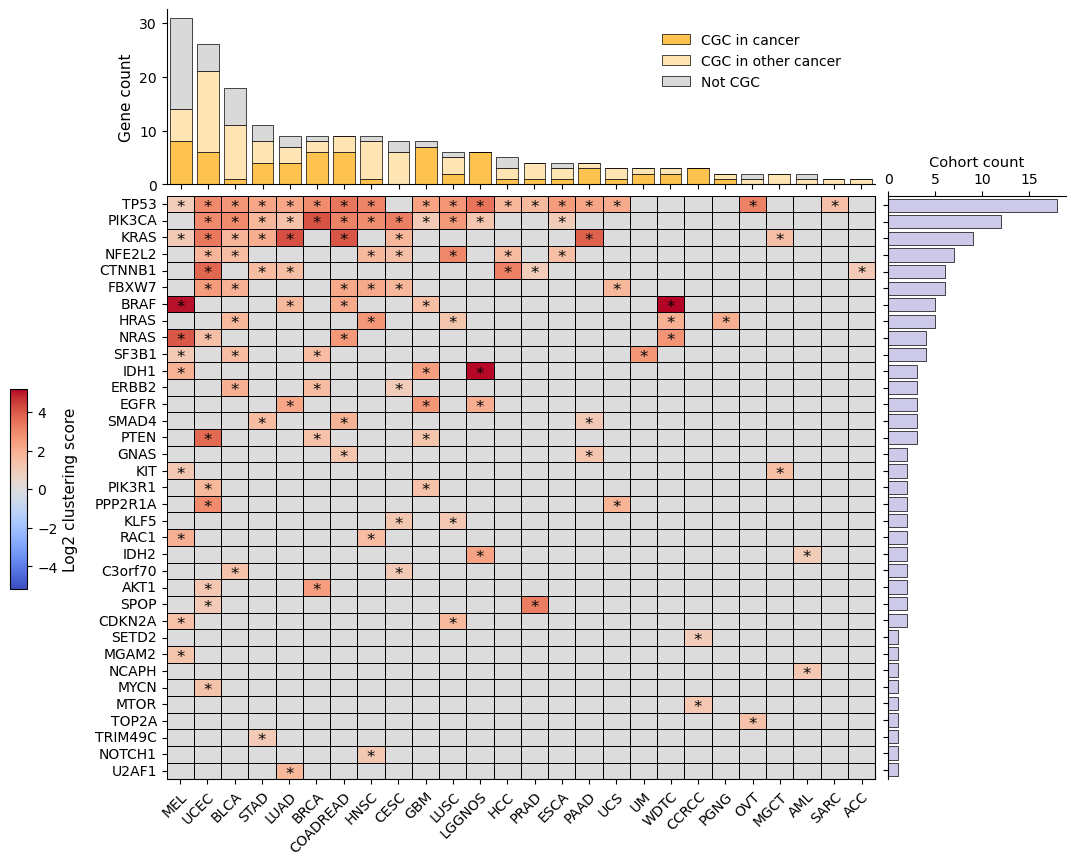

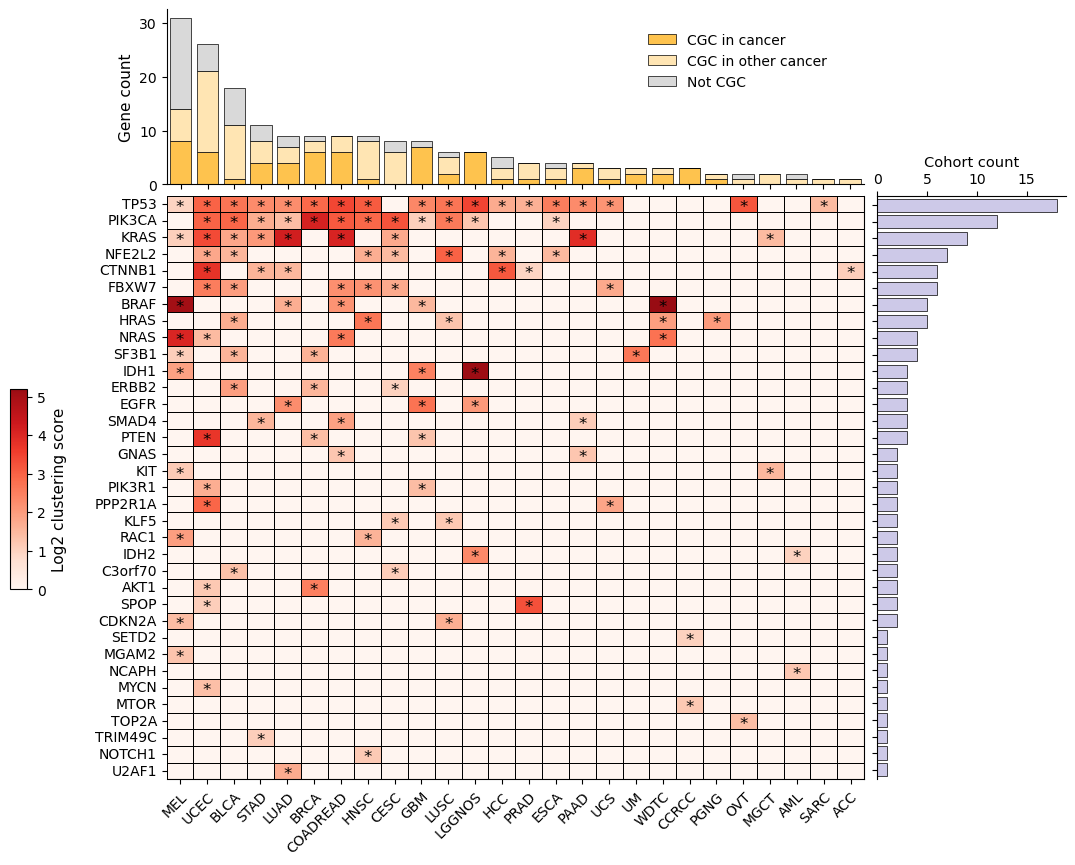

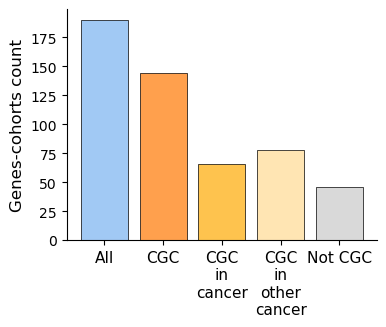

In [2194]:
top_cohorts_n=None
top_genes_n=35

o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict,
                                                                                  cgc_specific=True,
                                                                                  cgc_df=cgc_df, 
                                                                                  cohorts_parent_dict=cohorts_tissue_parent_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=False,
                                                                                  cgc_specific=True,
                                                                                  cgc_df=cgc_df, 
                                                                                  cohorts_parent_dict=cohorts_tissue_parent_dict)

df_anomaly.columns = [cohort.split("_")[2] for cohort in df_anomaly.columns]
gene_colors, lut = get_gene_annotation(df_binary, genetable)

plot_landscape(df=df_binary, 
               gene_colors=gene_colors, 
               gene_hits_count=gene_hits_count, 
               cohort_hits_count=cohort_hits_count,
               lut=lut, 
               df_anomaly=df_anomaly,
               figsize=(11.6,10),
               width_ratios=[1, 0.25],
               height_ratios=[0.3, 1],
               legend_box=(-0.2, 1.3),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.03,
               divergent_palette=True,
               plot_cgc_specific=True)

plot_landscape(df=df_binary, 
               gene_colors=gene_colors, 
               gene_hits_count=gene_hits_count, 
               cohort_hits_count=cohort_hits_count,
               lut=lut, 
               df_anomaly=df_anomaly,
               figsize=(11.6,10),
               width_ratios=[1, 0.27],
               height_ratios=[0.3, 1],
               legend_box=(-0.2, 1.3),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.03,
               filename="landscape_heatmap_tcga.png",
               plot_cgc_specific=True)


## Get summary CGC hits across genetable
s = hits_df[["Oncodrive3D", "CGC", "CGC_specific", "CGC_not_specific", "Not_CGC"]].sum()
s.index = "All", "CGC", "CGC\nin\ncancer", "CGC\nin\nother\ncancer", "Not CGC"

plt.figure(figsize=(4, 3))
plt.bar(s.index, s.values, color=["#A1C9F4", "#ffa04d", "#fec34e", "#ffe5b3", "#d9d9d9"], edgecolor='black', lw=0.5)

plt.xlabel(None)
plt.ylabel('Genes-cohorts count', fontsize=12)
plt.xticks(fontsize=11)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# WORKING HERE

## Notes
- Add TOP bar colors according to the CGC in cancer, CGC in other cancer, not CGC __> Done <__
- Group all cohorts by cancer type
- Add annotation axis on the right to annotated for CGC, OncoKB, Fishy, whatever else.. plus IntOGen hit, each individual method in IntOGen
    - AFTER CONSENSUS VOTING or ANY HIT?
- I could color the RIGHT bar according to the cancer type (probably, not really useful for TCGA but useful for the all cohorts one)

### All cohorts grouped by general cancer type

In [2201]:
def get_anomaly_df(genetable_df, o3d_output_dir):
    
    lst_cohort = []
    for cohort in genetable_df.Cohort.unique():
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        df_cohort = pd.read_csv(f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv")
        df_cohort = df_cohort[["Cohort", "Gene", "Uniprot_ID", "qval", "C_gene", "C_pos", "Score_obs_sim_top_vol"]]
        df_cohort = df_cohort.dropna(subset="qval").rename(columns={"Score_obs_sim_top_vol" : "Clustering_score"})
        lst_cohort.append(df_cohort)

    anomaly_df = pd.concat(lst_cohort).reset_index(drop=True)
    anomaly_df = anomaly_df.merge(genetable_df[["Cohort", "Gene", "CGC", "Fish"]].drop_duplicates(), on=["Cohort", "Gene"], how="left")
    anomaly_df.Cohort = anomaly_df.Cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
    
    return anomaly_df
    

def get_hits(genetable_df, alpha=0.01):
    
    genetable_df = genetable_df[genetable_df["o3d_qval"] < 0.01]
    genetable_df = genetable_df[["Gene", "Uniprot_ID", "Cancer", "Cohort", "CGC", "Fish", "o3d_qval"]].reset_index(drop=True)
    genetable_df = genetable_df.rename(columns={"o3d_qval" : "Oncodrive3D"})
    genetable_df["Oncodrive3D"] = 1
    
    return genetable_df


def get_cgc_specific(hits_df, cgc_df, cohorts_parent_dict):

    hits_df["General_cancer"] = hits_df.Cancer.apply(lambda x: cohorts_parent_dict[x])
    hits_df["CGC_specific"] = hits_df.apply(lambda x: 
                                        x["General_cancer"] in cgc_df[cgc_df["Gene Symbol"] == x["Gene"]].GENERAL_CANCER_TYPE.values[0] 
                                        if x["CGC"] == 1 else 0, axis=1).astype(int)
    hits_df["Not_CGC"] = hits_df.apply(lambda x: 1 if x["CGC"] != 1 else 0, axis=1)
    hits_df["CGC_not_specific"] = hits_df.apply(lambda x: 1 if x["CGC"] == 1 and x["CGC_specific"] == 0 else 0, axis=1)

    return hits_df


def get_gene_cohorts_binary(genetable_df, 
                            cohort_df, 
                            top_cohorts_n=None, 
                            top_genes_n=None, 
                            anomaly_dict=None,
                            rm_empty_cols=True,
                            log_score=True,
                            cgc_specific=False,
                            cgc_df=None, 
                            cohorts_parent_dict=None):

    hits_df = get_hits(genetable_df)
    gene_hits_count = hits_df.groupby("Gene").sum()[["Oncodrive3D"]].sort_values("Oncodrive3D", ascending=False)
    cohort_hits_count = hits_df.groupby("Cohort").sum()[["Oncodrive3D"]].sort_values("Oncodrive3D", ascending=False)
    if top_genes_n is None:
        top_genes_n = len(gene_hits_count)
    if top_cohorts_n is None:
        top_cohorts_n = len(cohort_hits_count)
    top_genes = gene_hits_count[:top_genes_n].index
    top_cohorts = cohort_hits_count[:top_cohorts_n].index
    
    df = pd.DataFrame(0, index=top_cohorts, columns=top_genes)
    for cohort in top_cohorts:
        genes = hits_df[hits_df["Cohort"] == cohort].Gene.values
        genes = [gene for gene in genes if gene in df.columns]
        if anomaly_dict:
            scores = [np.log(anomaly_dict[f"{gene}-{cohort}"]) if log_score else anomaly_dict[f"{gene}-{cohort}"] for gene in genes]    
            df.loc[cohort, genes] = scores
        else:
            df.loc[cohort, genes] = 1
    
    df = df.T 
    if len(cohort_df) == 1:
        df = df.loc[hits_df.Gene]
        
    if rm_empty_cols:
        if anomaly_dict:
            df = df.loc[:, ~(df == 0).all()]
        else:
            df = df.loc[:, ~(df == False).all()]

    gene_hits_count = gene_hits_count.loc[df.index]
    cohort_hits_count = cohort_hits_count.loc[[cohort for cohort in cohort_hits_count.index if cohort in df.columns]]

    if cgc_specific:
        hits_df = get_cgc_specific(hits_df, cgc_df, cohorts_parent_dict)
        cohort_cgc_count = hits_df.groupby("Cohort").apply(lambda x: pd.Series({
                "CGC_specific": sum(x["CGC_specific"]),
                "CGC_not_specific": sum(x["CGC_not_specific"]),
                "Not_CGC": sum(x["Not_CGC"])
            })).reset_index()
        
    else:
        hits_df["Not_CGC"] = hits_df.apply(lambda x: 1 if x["CGC"] != 1 else 0, axis=1)
        cohort_cgc_count = hits_df.groupby("Cohort").apply(lambda x: pd.Series({
            "CGC": sum(x["CGC"]),
            "Not_CGC": sum(x["Not_CGC"])
        })).reset_index()

    
    cohort_hits_count = cohort_hits_count.merge(cohort_cgc_count, on="Cohort")
    
    return df, hits_df, gene_hits_count, cohort_hits_count


def get_cgc_specific_count_for_ttype(hits_df_ttype):

    hits_df_ttype = hits_df_ttype[["Gene", "Oncodrive3D", "CGC_specific", "Not_CGC", "CGC_not_specific"]].drop_duplicates().reset_index(drop=True)
    hits_df_ttype = hits_df_ttype.drop(columns=["Gene"]).sum()

    return hits_df_ttype


def get_gene_cancers_binary(genetable_df, 
                            cohort_df, 
                            top_cohorts_n=None, 
                            top_genes_n=None, 
                            anomaly_dict=None,
                            rm_empty_cols=True,
                            log_score=True,
                            cgc_specific=False,
                            cgc_df=None, 
                            cohorts_parent_dict=None):

    # Get hits with CGC specific info
    hits_df = get_hits(genetable)
    hits_df = get_cgc_specific(hits_df, cgc_df, cohorts_tissue_parent_dict)
    hits_df = hits_df.drop(columns=["Uniprot_ID", "Cancer", "Cohort", "Fish"]).drop_duplicates().reset_index(drop=True)
    
    # Get count of cancer a gene has been detected as significant across all cohorts
    gene_hits_count = hits_df.groupby("Gene").apply(lambda x: len(x)).reset_index(name="Oncodrive3D").sort_values("Oncodrive3D", ascending=False).set_index("Gene")
    
    # For a general cancer type get the number of unique CGC genes in that cancer, other cancer, not CGC
    cancer_hits_count = hits_df.groupby("General_cancer").apply(lambda x: get_cgc_specific_count_for_ttype(x)).sort_values("Oncodrive3D", ascending=False)

    if top_genes_n is None:
        top_genes_n = len(gene_hits_count)
    if top_cohorts_n is None:
        top_cohorts_n = len(cancer_hits_count)
    
    top_genes = gene_hits_count[:top_genes_n].index
    top_cohorts = cancer_hits_count[:top_cohorts_n].index

    
    df = pd.DataFrame(0, index=top_cohorts, columns=top_genes)
    for cohort in top_cohorts:
        genes = hits_df[hits_df["General_cancer"] == cohort].Gene.values
        genes = [gene for gene in genes if gene in df.columns]
        if anomaly_dict:
            scores = [np.log(anomaly_dict[f"{gene}-{cohort}"]) if log_score else anomaly_dict[f"{gene}-{cohort}"] for gene in genes]    
            df.loc[cohort, genes] = scores
        else:
            df.loc[cohort, genes] = 1
    
    df = df.T 
    if len(cohort_df) == 1:
        df = df.loc[hits_df.Gene]
        
    if rm_empty_cols:
        if anomaly_dict:
            df = df.loc[:, ~(df == 0).all()]
        else:
            df = df.loc[:, ~(df == False).all()]


    gene_hits_count = gene_hits_count.loc[df.index]
    cancer_hits_count = cancer_hits_count.loc[[cohort for cohort in cancer_hits_count.index if cohort in df.columns]]

    return df, hits_df, gene_hits_count, cancer_hits_count

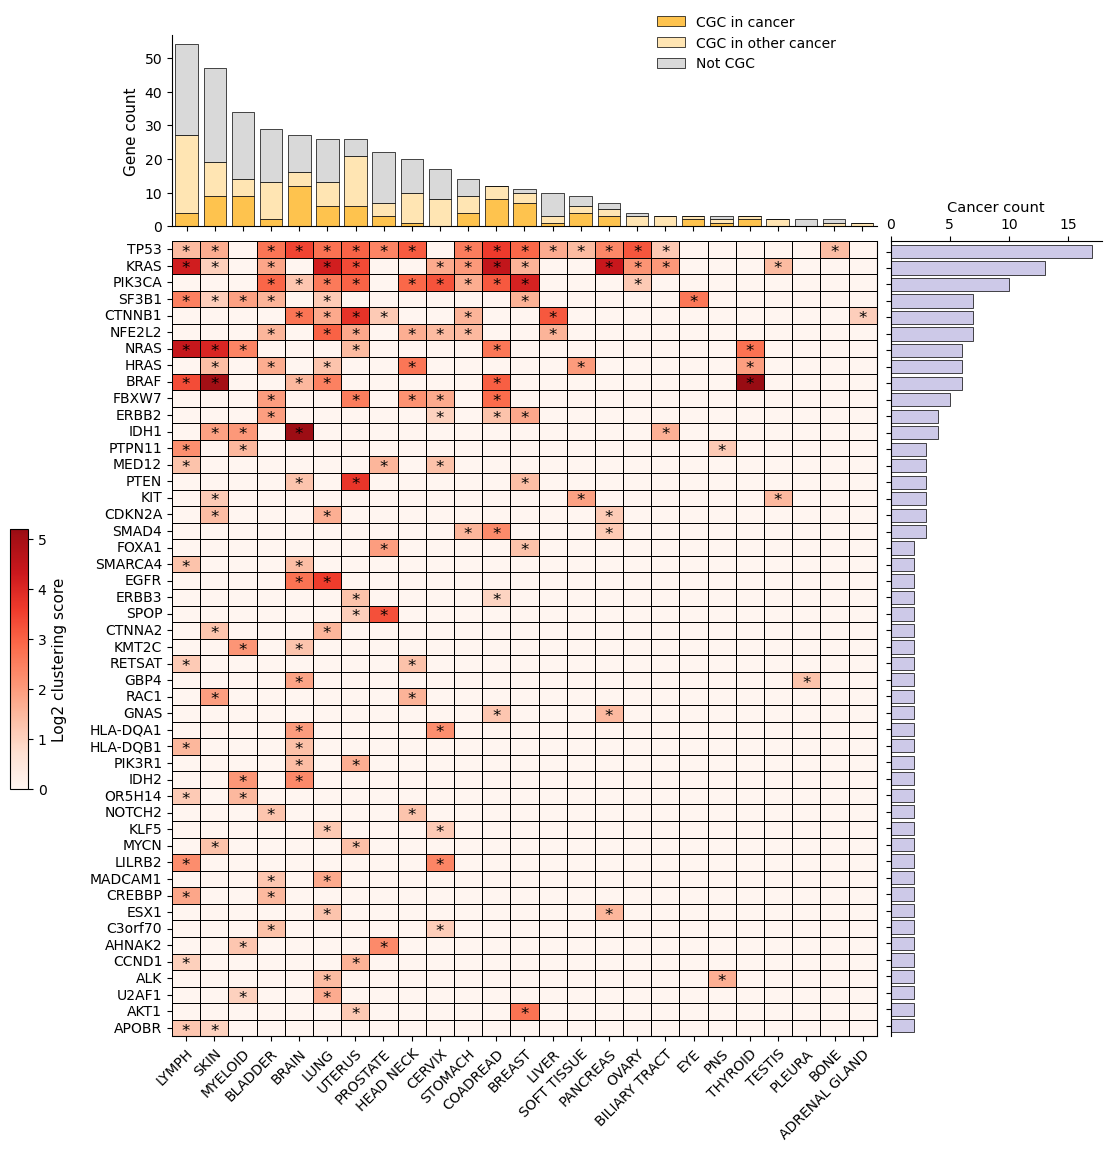

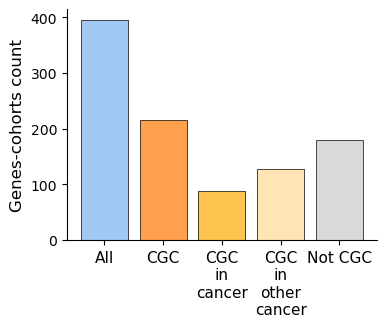

In [2204]:
top_cohorts_n=None
top_genes_n=48 

o3d_output = get_anomaly_df(genetable, o3d_output_dir)
o3d_output = o3d_output.merge(cohort_df.rename(columns={"COHORT" : "Cohort"})[["Cohort", "GENERAL_CANCER_TYPE"]], on="Cohort")
o3d_output = o3d_output[["GENERAL_CANCER_TYPE", 'Gene', "Clustering_score"]].groupby(["GENERAL_CANCER_TYPE", 'Gene']).max().reset_index()

anomaly_dict = {f"{gene}-{cancer}" : score for gene, cancer, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["GENERAL_CANCER_TYPE"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cancers_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict,
                                                                                  cgc_specific=True,
                                                                                  cgc_df=cgc_df, 
                                                                                  cohorts_parent_dict=cohorts_tissue_parent_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cancers_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=False,
                                                                                  cgc_specific=True,
                                                                                  cgc_df=cgc_df, 
                                                                                  cohorts_parent_dict=cohorts_tissue_parent_dict)

df_anomaly.columns = [cancer.replace("_", " ") for cancer in df_anomaly.columns]
gene_colors, lut = get_gene_annotation(df_binary, genetable)

plot_landscape(df=df_binary, 
               gene_colors=gene_colors, 
               gene_hits_count=gene_hits_count, 
               cohort_hits_count=cohort_hits_count,
               lut=lut, 
               df_anomaly=df_anomaly,
               figsize=(12,13),
               width_ratios=[1, 0.3],
               height_ratios=[0.24, 1],
               legend_box=(-0.2, 1.3),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.03,
               plot_cgc_specific=True,
               right_ax_ylabel="Cancer count")


## Get summary CGC hits across genetable
s = hits_df[["Oncodrive3D", "CGC", "CGC_specific", "CGC_not_specific", "Not_CGC"]].sum()
s.index = "All", "CGC", "CGC\nin\ncancer", "CGC\nin\nother\ncancer", "Not CGC"

plt.figure(figsize=(4, 3))
plt.bar(s.index, s.values, color=["#A1C9F4", "#ffa04d", "#fec34e", "#ffe5b3", "#d9d9d9"], edgecolor='black', lw=0.5)

plt.xlabel(None)
plt.ylabel('Genes-cohorts count', fontsize=12)
plt.xticks(fontsize=11)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Clean up the following (AFTER RESTARTING THE KERNEL AND RE-RUNNING DOWN HERE)

In [1990]:
hits_df = get_hits(genetable)
hits_df = get_cgc_specific(hits_df, cgc_df, cohorts_tissue_parent_dict)
hits_df

,Gene,Uniprot_ID,Cancer,Cohort,CGC,Fish,Oncodrive3D,General_cancer,CGC_specific,Not_CGC,CGC_not_specific
0,PIK3CA,P42336,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,BLADDER,0,0,1
1,RXRA,F1D8Q5,BLCA,HARTWIG_WGS_BLCA_2023,0,0,1,BLADDER,0,1,0
2,FGFR3,P22607,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,BLADDER,1,0,0
3,FBXW7,Q969H0,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,BLADDER,0,0,1
4,TP53,K7PPA8,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,BLADDER,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
614,MED12,Q93074,PRAD,TCGA_WXS_PRAD,1,0,1,PROSTATE,0,0,1
615,CTNNB1,A0A024R2Q3,PRAD,TCGA_WXS_PRAD,1,0,1,PROSTATE,0,0,1
616,TP53,K7PPA8,SOFT_TISSUE,TCGA_WXS_SARC,1,0,1,SOFT_TISSUE,0,0,1
617,HRAS,P01112,PGNG,TCGA_WXS_PGNG,1,0,1,SOFT_TISSUE,0,0,1


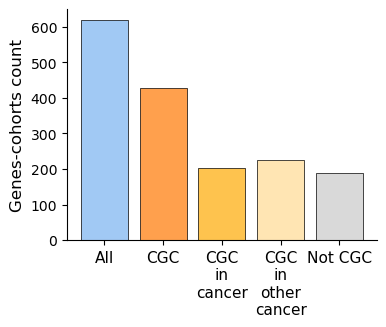

In [1991]:
## Get summary CGC hits across genetable
s = hits_df[["Oncodrive3D", "CGC", "CGC_specific", "CGC_not_specific", "Not_CGC"]].sum()
s.index = "All", "CGC", "CGC\nin\ncancer", "CGC\nin\nother\ncancer", "Not CGC"

plt.figure(figsize=(4, 3))
plt.bar(s.index, s.values, color=["#A1C9F4", "#ffa04d", "#fec34e", "#ffe5b3", "#d9d9d9"], edgecolor='black', lw=0.5)

plt.xlabel(None)
plt.ylabel('Genes-cohorts count', fontsize=12)
plt.xticks(fontsize=11)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [1992]:
# Get number of cohorts of a given general cancer type where each gene has been detected 
lung_df = hits_df[hits_df["General_cancer"] == "LUNG"]

lung_gene_hits_count = lung_df.groupby("Gene").sum()["Oncodrive3D"].reset_index()
lung_gene_hits_count = lung_gene_hits_count.sort_values("Oncodrive3D", ascending=False).reset_index(drop=True)
lung_gene_hits_count

,Gene,Oncodrive3D
0,TP53,10
1,KRAS,8
2,EGFR,5
3,PIK3CA,4
4,NFE2L2,2
5,BRAF,2
6,CTNNB1,2
7,U2AF1,2
8,ZNF395,1
9,UGT2B17,1


In [2111]:
def get_cgc_specific_count_for_ttype(hits_df_ttype):

    hits_df_ttype = hits_df_ttype[["Gene", "CGC_specific", "Not_CGC", "CGC_not_specific"]].drop_duplicates().reset_index(drop=True)
    hits_df_ttype = hits_df_ttype.drop(columns=["Gene", "Uniprot_ID"]).sum()

    return hits_df_ttype

# For a general cancer type get the number of unique CGC genes in that cancer, other cancer, not CGC
hits_df_ttype = hits_df.groupby("General_cancer").apply(lambda x: get_cgc_specific_count_for_ttype(x)).sort_values("Oncodrive3D", ascending=False).reset_index()
hits_df_ttype

In [2063]:
top_cohorts_n=40
top_genes_n=40 

o3d_output = get_anomaly_df(genetable, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

# df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
#                                                                                   cohort_df, 
#                                                                                   top_cohorts_n=top_cohorts_n, 
#                                                                                   top_genes_n=top_genes_n, 
#                                                                                   anomaly_dict=anomaly_dict)

# df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
#                                                                                   cohort_df, 
#                                                                                   top_cohorts_n=top_cohorts_n, 
#                                                                                   top_genes_n=top_genes_n, 
#                                                                                   anomaly_dict=False)

In [2045]:
cohort_df

,COHORT,CANCER_TYPE,PLATFORM,MUTATIONS,SAMPLES,GENERAL_CANCER_TYPE
0,HARTWIG_WGS_BLCA_2023,BLCA,WGS,5017561,144,BLADDER
1,HARTWIG_WGS_EGC_2023,EGC,WGS,573540,21,STOMACH
2,HARTWIG_WGS_LMS_2023,LMS,WGS,339549,43,SOFT_TISSUE
3,CBIOP_WGS_STAD_ONCOSG_2018,STAD,WGS,861309,147,STOMACH
4,CBIOP_WXS_CM_VALLEN_2018,MEL,WXS,132960,151,SKIN
...,...,...,...,...,...,...
266,TCGA_WXS_PRCC,PRCC,WXS,34566,276,KIDNEY
267,TCGA_WXS_PRAD,PRAD,WXS,34239,494,PROSTATE
268,TCGA_WXS_PLMESO,PLMESO,WXS,3980,82,PLEURA
269,TCGA_WXS_SARC,SARC,WXS,31484,234,SOFT_TISSUE


### Good one

In [2080]:
top_cohorts_n=40
top_genes_n=40 

o3d_output = get_anomaly_df(genetable, o3d_output_dir)
o3d_output = o3d_output.merge(cohort_df.rename(columns={"COHORT" : "Cohort"})[["Cohort", "GENERAL_CANCER_TYPE"]], on="Cohort")
o3d_output = o3d_output[["GENERAL_CANCER_TYPE", 'Gene', "Clustering_score"]].groupby(["GENERAL_CANCER_TYPE", 'Gene']).max().reset_index()

anomaly_dict = {f"{gene}-{cancer}" : score for gene, cancer, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["GENERAL_CANCER_TYPE"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cancers_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict,
                                                                                  cgc_specific=True,
                                                                                  cgc_df=cgc_df, 
                                                                                  cohorts_parent_dict=cohorts_tissue_parent_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cancers_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=False,
                                                                                  cgc_specific=True,
                                                                                  cgc_df=cgc_df, 
                                                                                  cohorts_parent_dict=cohorts_tissue_parent_dict)

gene_colors, lut = get_gene_annotation(df_binary, genetable)

plot_landscape(df=df_binary, 
               gene_colors=gene_colors, 
               gene_hits_count=gene_hits_count, 
               cohort_hits_count=cohort_hits_count,
               lut=lut, 
               df_anomaly=df_anomaly,
               figsize=(11,10),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-0.2, 1.3),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.03,
               plot_cgc_specific=True)

,GENERAL_CANCER_TYPE,Gene,Clustering_score
0,ADRENAL_GLAND,ADAM33,1.653467
1,ADRENAL_GLAND,ADGRL4,1.604568
2,ADRENAL_GLAND,BACH2,1.891935
3,ADRENAL_GLAND,CLTB,1.239211
4,ADRENAL_GLAND,CRYAB,1.467292
...,...,...,...
48227,VULVA,ZNF142,1.942959
48228,VULVA,ZNF285,1.809062
48229,VULVA,ZNF385B,1.458845
48230,VULVA,ZNF418,1.746603


In [2081]:
anomaly_dict = {f"{gene}-{cancer}" : score for gene, cancer, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["GENERAL_CANCER_TYPE"].values, 
                                                                          o3d_output["Clustering_score"].values)}
anomaly_dict

{'ADAM33-ADRENAL_GLAND': 1.653467166256414,
 'ADGRL4-ADRENAL_GLAND': 1.60456808287175,
 'BACH2-ADRENAL_GLAND': 1.8919352214734664,
 'CLTB-ADRENAL_GLAND': 1.2392110279502682,
 'CRYAB-ADRENAL_GLAND': 1.4672919514145064,
 'CTNNB1-ADRENAL_GLAND': 2.9687460714975957,
 'DLGAP3-ADRENAL_GLAND': 1.9291096350326784,
 'GLB1L2-ADRENAL_GLAND': 1.476214830039982,
 'MAP3K14-ADRENAL_GLAND': 1.846207608842762,
 'MICALL1-ADRENAL_GLAND': 1.810169022125833,
 'MTRFR-ADRENAL_GLAND': 0.9198072046128696,
 'OR4N2-ADRENAL_GLAND': 0.8705226732081196,
 'PLAGL1-ADRENAL_GLAND': 1.7100883404789358,
 'PLEKHG6-ADRENAL_GLAND': 1.2467086576029298,
 'POLE-ADRENAL_GLAND': 1.8797973489226292,
 'SDS-ADRENAL_GLAND': 1.2192647862500958,
 'SKIC2-ADRENAL_GLAND': 1.5051460461348627,
 'SLC10A2-ADRENAL_GLAND': 1.4032719984803392,
 'SLC25A37-ADRENAL_GLAND': 1.4732521149912188,
 'SLIT2-ADRENAL_GLAND': 1.5291625658616377,
 'SMC3-ADRENAL_GLAND': 1.2827438232386354,
 'TP53-ADRENAL_GLAND': 1.4984790586354684,
 'ZNF804B-ADRENAL_GLAND': 2

In [2170]:
df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cancers_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict,
                                                                                  cgc_specific=True,
                                                                                  cgc_df=cgc_df, 
                                                                                  cohorts_parent_dict=cohorts_tissue_parent_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cancers_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=False,
                                                                                  cgc_specific=True,
                                                                                  cgc_df=cgc_df, 
                                                                                  cohorts_parent_dict=cohorts_tissue_parent_dict)


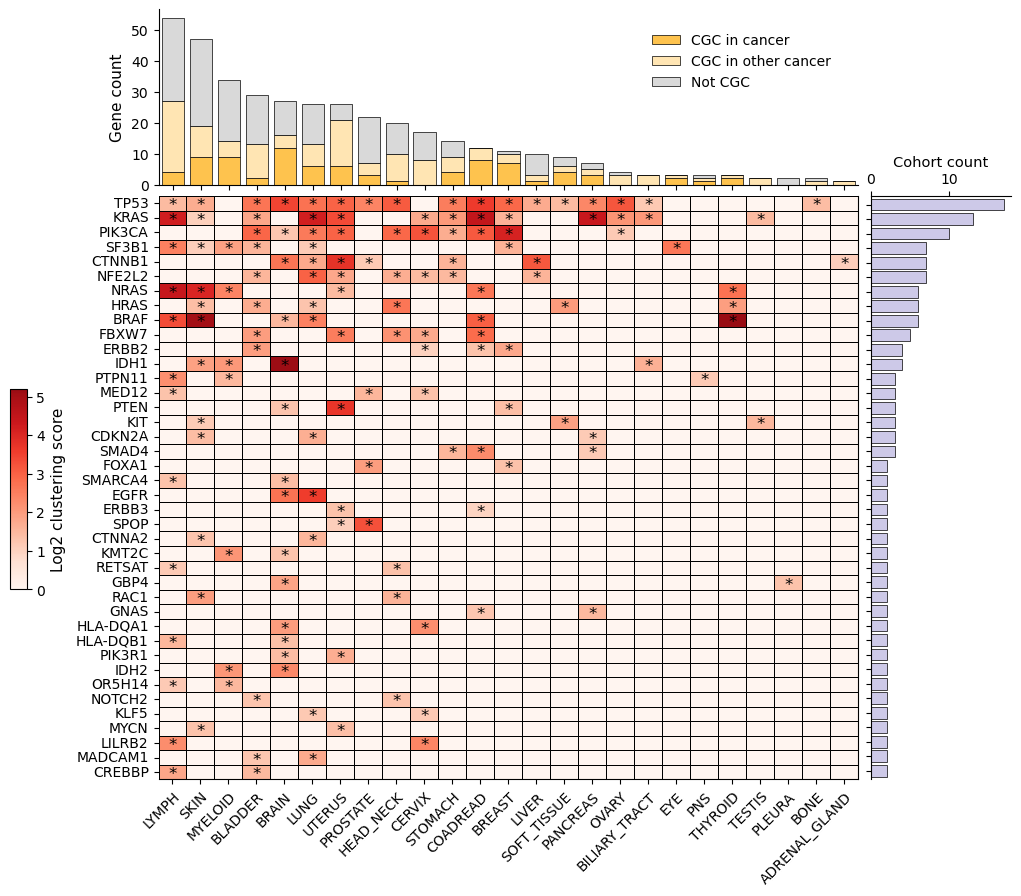

In [2171]:
gene_colors, lut = get_gene_annotation(df_binary, genetable)

plot_landscape(df=df_binary, 
               gene_colors=gene_colors, 
               gene_hits_count=gene_hits_count, 
               cohort_hits_count=cohort_hits_count,
               lut=lut, 
               df_anomaly=df_anomaly,
               figsize=(11,10),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-0.2, 1.3),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.03,
               plot_cgc_specific=True)

In [2114]:
# Get count of cancer a gene has been detected as significant across all cohorts

hits_df = get_hits(genetable)
hits_df = get_cgc_specific(hits_df, cgc_df, cohorts_tissue_parent_dict)
hits_df = hits_df.drop(columns=["Uniprot_ID", "Cancer", "Cohort", "Fish"]).drop_duplicates().reset_index(drop=True)
gene_hits_count = hits_df.groupby("Gene").apply(lambda x: sum(x["Oncodrive3D"])).reset_index(name="Cancer_count").sort_values("Cancer_count", ascending=False)
gene_hits_count

,Gene,Cancer_count
240,TP53,17
139,KRAS,13
180,PIK3CA,10
210,SF3B1,7
55,CTNNB1,7
...,...,...
104,H3-3A,1
105,H3C2,1
106,HCAR3,1
107,HLA-A,1


In [2115]:
# lung_gene_hits_count = lung_df.groupby("Gene").sum()["Oncodrive3D"].reset_index()
# lung_gene_hits_count = lung_gene_hits_count.sort_values("Oncodrive3D", ascending=False).reset_index(drop=True)
# lung_gene_hits_count

In [ ]:
df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict,
                                                                                  cgc_specific=True,
                                                                                  cgc_df=cgc_df, 
                                                                                  cohorts_parent_dict=cohorts_tissue_parent_dict)

In [2122]:
def get_cgc_specific_count_for_ttype(hits_df_ttype):

    hits_df_ttype = hits_df_ttype[["Gene", "Oncodrive3D", "CGC_specific", "Not_CGC", "CGC_not_specific"]].drop_duplicates().reset_index(drop=True)
    hits_df_ttype = hits_df_ttype.drop(columns=["Gene"]).sum()

    return hits_df_ttype


# For a general cancer type get the number of unique CGC genes in that cancer, other cancer, not CGC
hits_df_ttype = hits_df.groupby("General_cancer").apply(lambda x: get_cgc_specific_count_for_ttype(x)).sort_values("Oncodrive3D", ascending=False).reset_index()
hits_df_ttype

,General_cancer,Oncodrive3D,CGC_specific,Not_CGC,CGC_not_specific
0,LYMPH,54,4,27,23
1,SKIN,47,9,28,10
2,MYELOID,34,9,20,5
3,BLADDER,29,2,16,11
4,BRAIN,27,12,11,4
5,LUNG,26,6,13,7
6,UTERUS,26,6,5,15
7,PROSTATE,22,3,15,4
8,HEAD_NECK,20,1,10,9
9,CERVIX,17,0,9,8


In [2119]:
hits_df

,Gene,CGC,Oncodrive3D,General_cancer,CGC_specific,Not_CGC,CGC_not_specific
0,PIK3CA,1,1,BLADDER,0,0,1
1,RXRA,0,1,BLADDER,0,1,0
2,FGFR3,1,1,BLADDER,1,0,0
3,FBXW7,1,1,BLADDER,0,0,1
4,TP53,1,1,BLADDER,0,0,1
...,...,...,...,...,...,...,...
390,TRIM49C,0,1,STOMACH,0,1,0
391,SPTA1,0,1,STOMACH,0,1,0
392,TP53,1,1,SOFT_TISSUE,0,0,1
393,HRAS,1,1,SOFT_TISSUE,0,0,1


In [2118]:
hits_df.groupby("General_cancer").apply(lambda x: get_cgc_specific_count_for_ttype(x))

,CGC_specific,Not_CGC,CGC_not_specific
General_cancer,,,
ADRENAL_GLAND,0,0,1
BILIARY_TRACT,0,0,3
BLADDER,2,16,11
BONE,0,1,1
BRAIN,12,11,4
BREAST,7,1,3
CERVIX,0,9,8
COADREAD,8,0,4
EYE,2,0,1


In [2168]:
def get_gene_cancers_binary(genetable_df, 
                            cohort_df, 
                            top_cohorts_n=None, 
                            top_genes_n=None, 
                            anomaly_dict=None,
                            rm_empty_cols=True,
                            log_score=True,
                            cgc_specific=False,
                            cgc_df=None, 
                            cohorts_parent_dict=None):

    # Get hits with CGC specific info
    hits_df = get_hits(genetable)
    hits_df = get_cgc_specific(hits_df, cgc_df, cohorts_tissue_parent_dict)
    hits_df = hits_df.drop(columns=["Uniprot_ID", "Cancer", "Cohort", "Fish"]).drop_duplicates().reset_index(drop=True)
    
    # Get count of cancer a gene has been detected as significant across all cohorts
    gene_hits_count = hits_df.groupby("Gene").apply(lambda x: len(x)).reset_index(name="Oncodrive3D").sort_values("Oncodrive3D", ascending=False).set_index("Gene")
    
    # For a general cancer type get the number of unique CGC genes in that cancer, other cancer, not CGC
    cancer_hits_count = hits_df.groupby("General_cancer").apply(lambda x: get_cgc_specific_count_for_ttype(x)).sort_values("Oncodrive3D", ascending=False)

    if top_genes_n is None:
        top_genes_n = len(gene_hits_count)
    if top_cohorts_n is None:
        top_cohorts_n = len(cancer_hits_count)
    
    top_genes = gene_hits_count[:top_genes_n].index
    top_cohorts = cancer_hits_count[:top_cohorts_n].index

    
    df = pd.DataFrame(0, index=top_cohorts, columns=top_genes)
    for cohort in top_cohorts:
        genes = hits_df[hits_df["General_cancer"] == cohort].Gene.values
        genes = [gene for gene in genes if gene in df.columns]
        if anomaly_dict:
            scores = [np.log(anomaly_dict[f"{gene}-{cohort}"]) if log_score else anomaly_dict[f"{gene}-{cohort}"] for gene in genes]    
            df.loc[cohort, genes] = scores
        else:
            df.loc[cohort, genes] = 1
    
    df = df.T 
    if len(cohort_df) == 1:
        df = df.loc[hits_df.Gene]
        
    if rm_empty_cols:
        if anomaly_dict:
            df = df.loc[:, ~(df == 0).all()]
        else:
            df = df.loc[:, ~(df == False).all()]


    gene_hits_count = gene_hits_count.loc[df.index]
    cancer_hits_count = cancer_hits_count.loc[[cohort for cohort in cancer_hits_count.index if cohort in df.columns]]

    return df, hits_df, gene_hits_count, cancer_hits_count

In [2133]:
# Get hits with CGC specific info
hits_df = get_hits(genetable)
hits_df = get_cgc_specific(hits_df, cgc_df, cohorts_tissue_parent_dict)
hits_df = hits_df.drop(columns=["Uniprot_ID", "Cancer", "Cohort", "Fish"]).drop_duplicates().reset_index(drop=True)

# Get count of cancer a gene has been detected as significant across all cohorts
gene_hits_count = hits_df.groupby("Gene").apply(lambda x: len(x)).reset_index(name="Cancer_count").sort_values("Cancer_count", ascending=False).set_index("Gene")

# For a general cancer type get the number of unique CGC genes in that cancer, other cancer, not CGC
cohort_hits_count = hits_df.groupby("General_cancer").apply(lambda x: get_cgc_specific_count_for_ttype(x)).sort_values("Oncodrive3D", ascending=False)

In [2136]:
if top_genes_n is None:
    top_genes_n = len(gene_hits_count)
if top_cohorts_n is None:
    top_cohorts_n = len(cohort_hits_count)

top_genes = gene_hits_count[:top_genes_n].index
top_cohorts = cohort_hits_count[:top_cohorts_n].index

In [2139]:
hits_df

,Gene,CGC,Oncodrive3D,General_cancer,CGC_specific,Not_CGC,CGC_not_specific
0,PIK3CA,1,1,BLADDER,0,0,1
1,RXRA,0,1,BLADDER,0,1,0
2,FGFR3,1,1,BLADDER,1,0,0
3,FBXW7,1,1,BLADDER,0,0,1
4,TP53,1,1,BLADDER,0,0,1
...,...,...,...,...,...,...,...
390,TRIM49C,0,1,STOMACH,0,1,0
391,SPTA1,0,1,STOMACH,0,1,0
392,TP53,1,1,SOFT_TISSUE,0,0,1
393,HRAS,1,1,SOFT_TISSUE,0,0,1


In [2148]:
# log_score = True
rm_empty_cols=True


df = pd.DataFrame(0, index=top_cohorts, columns=top_genes)
for cohort in top_cohorts:
    genes = hits_df[hits_df["General_cancer"] == cohort].Gene.values
    genes = [gene for gene in genes if gene in df.columns]
    if anomaly_dict:
        scores = [np.log(anomaly_dict[f"{gene}-{cohort}"]) if log_score else anomaly_dict[f"{gene}-{cohort}"] for gene in genes]    
        df.loc[cohort, genes] = scores
    else:
        df.loc[cohort, genes] = 1

df = df.T 
if len(cohort_df) == 1:
    df = df.loc[hits_df.Gene]
    
if rm_empty_cols:
    if anomaly_dict:
        df = df.loc[:, ~(df == 0).all()]
    else:
        df = df.loc[:, ~(df == False).all()]

In [2151]:
gene_hits_count = gene_hits_count.loc[df.index]
cohort_hits_count = cohort_hits_count.loc[[cohort for cohort in cohort_hits_count.index if cohort in df.columns]]

### End

In [2026]:
def get_anomaly_df(genetable_df, o3d_output_dir):
    
    lst_cohort = []
    for cohort in genetable_df.Cohort.unique():
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        df_cohort = pd.read_csv(f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv")
        df_cohort = df_cohort[["Cohort", "Gene", "Uniprot_ID", "qval", "C_gene", "C_pos", "Score_obs_sim_top_vol"]]
        df_cohort = df_cohort.dropna(subset="qval").rename(columns={"Score_obs_sim_top_vol" : "Clustering_score"})
        lst_cohort.append(df_cohort)

    anomaly_df = pd.concat(lst_cohort).reset_index(drop=True)
    anomaly_df = anomaly_df.merge(genetable_df[["Cohort", "Gene", "CGC", "Fish"]].drop_duplicates(), on=["Cohort", "Gene"], how="left")
    anomaly_df.Cohort = anomaly_df.Cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
    
    return anomaly_df

In [2027]:
o3d_output = get_anomaly_df(genetable, o3d_output_dir)
o3d_output

,Cohort,Gene,Uniprot_ID,qval,C_gene,C_pos,Clustering_score,CGC,Fish
0,HARTWIG_WGS_BLCA_2023,PIK3CA,P42336,0.0,1.0,[542 545 539],6.608875,1.0,0.0
1,HARTWIG_WGS_BLCA_2023,RXRA,F1D8Q5,0.0,1.0,[427 429],5.260005,0.0,0.0
2,HARTWIG_WGS_BLCA_2023,FGFR3,P22607,0.0,1.0,[248 249 373],5.135854,1.0,0.0
3,HARTWIG_WGS_BLCA_2023,FBXW7,Q969H0,0.0,1.0,[505 465],3.409612,1.0,0.0
4,HARTWIG_WGS_BLCA_2023,TP53,K7PPA8,0.0,1.0,[249 273 241 173 248 132 195 280 157 258 194 2...,3.377812,1.0,0.0
...,...,...,...,...,...,...,...,...,...
71189,TCGA_WXS_PGNG,SUSD4,Q5VX71,1.0,0.0,NaN,1.668006,0.0,0.0
71190,TCGA_WXS_PGNG,PMM1,A0A024R1U5,1.0,0.0,NaN,1.332350,0.0,0.0
71191,TCGA_WXS_PGNG,NAGK,A0A384N6G7,1.0,0.0,NaN,1.287737,0.0,0.0
71192,TCGA_WXS_PGNG,ADH6,P28332,1.0,0.0,NaN,1.279473,0.0,1.0


In [2031]:
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}
hits_df = get_hits(genetable)
hits_df

,Gene,Uniprot_ID,Cancer,Cohort,CGC,Fish,Oncodrive3D
0,PIK3CA,P42336,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1
1,RXRA,F1D8Q5,BLCA,HARTWIG_WGS_BLCA_2023,0,0,1
2,FGFR3,P22607,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1
3,FBXW7,Q969H0,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1
4,TP53,K7PPA8,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1
...,...,...,...,...,...,...,...
614,MED12,Q93074,PRAD,TCGA_WXS_PRAD,1,0,1
615,CTNNB1,A0A024R2Q3,PRAD,TCGA_WXS_PRAD,1,0,1
616,TP53,K7PPA8,SOFT_TISSUE,TCGA_WXS_SARC,1,0,1
617,HRAS,P01112,PGNG,TCGA_WXS_PGNG,1,0,1


In [2033]:
hits_df["Clustering_score"] = hits_df.apply(lambda x: anomaly_dict[f"{x.Gene}-{x.Cohort}"], axis=1)
hits_df

,Gene,Uniprot_ID,Cancer,Cohort,CGC,Fish,Oncodrive3D,Clustering_score
0,PIK3CA,P42336,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,6.608875
1,RXRA,F1D8Q5,BLCA,HARTWIG_WGS_BLCA_2023,0,0,1,5.260005
2,FGFR3,P22607,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,5.135854
3,FBXW7,Q969H0,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,3.409612
4,TP53,K7PPA8,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,3.377812
...,...,...,...,...,...,...,...,...
614,MED12,Q93074,PRAD,TCGA_WXS_PRAD,1,0,1,3.834154
615,CTNNB1,A0A024R2Q3,PRAD,TCGA_WXS_PRAD,1,0,1,2.550003
616,TP53,K7PPA8,SOFT_TISSUE,TCGA_WXS_SARC,1,0,1,4.302525
617,HRAS,P01112,PGNG,TCGA_WXS_PGNG,1,0,1,7.463746


In [2034]:
hits_df = get_cgc_specific(hits_df, cgc_df, cohorts_tissue_parent_dict)
hits_df

,Gene,Uniprot_ID,Cancer,Cohort,CGC,Fish,Oncodrive3D,Clustering_score,General_cancer,CGC_specific,Not_CGC,CGC_not_specific
0,PIK3CA,P42336,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,6.608875,BLADDER,0,0,1
1,RXRA,F1D8Q5,BLCA,HARTWIG_WGS_BLCA_2023,0,0,1,5.260005,BLADDER,0,1,0
2,FGFR3,P22607,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,5.135854,BLADDER,1,0,0
3,FBXW7,Q969H0,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,3.409612,BLADDER,0,0,1
4,TP53,K7PPA8,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,3.377812,BLADDER,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
614,MED12,Q93074,PRAD,TCGA_WXS_PRAD,1,0,1,3.834154,PROSTATE,0,0,1
615,CTNNB1,A0A024R2Q3,PRAD,TCGA_WXS_PRAD,1,0,1,2.550003,PROSTATE,0,0,1
616,TP53,K7PPA8,SOFT_TISSUE,TCGA_WXS_SARC,1,0,1,4.302525,SOFT_TISSUE,0,0,1
617,HRAS,P01112,PGNG,TCGA_WXS_PGNG,1,0,1,7.463746,SOFT_TISSUE,0,0,1


In [2041]:
hits_df[hits_df["General_cancer"] == "LUNG"].groupby("Gene").max()

,Uniprot_ID,Cancer,Cohort,CGC,Fish,Oncodrive3D,Clustering_score,General_cancer,CGC_specific,Not_CGC,CGC_not_specific
Gene,,,,,,,,,,,
ALK,Q9UM73,NSCLC,HARTWIG_WGS_NSCLC_2023,1,0,1,4.137430,LUNG,1,0,0
ATG2A,Q2TAZ0,LUAD,CBIOP_WXS_LUAD_VALLEN_2018,0,0,1,3.621890,LUNG,0,1,0
BRAF,P15056,NSCLC,TCGA_WXS_LUAD,1,0,1,11.651959,LUNG,1,0,0
CDKN2A,K7PML8,LUSC,TCGA_WXS_LUSC,1,0,1,5.202005,LUNG,0,0,1
CTNNA2,P26232,LUAD,CBIOP_WXS_LUAD_VALLEN_2018,1,0,1,4.683756,LUNG,0,0,1
CTNNB1,A0A024R2Q3,NSCLC,TCGA_WXS_LUAD,1,0,1,5.886094,LUNG,0,0,1
EGFR,P00533,NSCLC,TCGA_WXS_LUAD,1,0,1,35.581750,LUNG,1,0,0
EPPK1,P58107,LUAD,CBIOP_WXS_LUAD_ONCOSG_2020,0,0,1,5.047566,LUNG,0,1,0
ESX1,Q8N693,LUAD,CBIOP_WXS_LUAD_ONCOSG_2020,0,1,1,3.558724,LUNG,0,1,0


In [ ]:
def get_hits(genetable_df, alpha=0.01):
    
    genetable_df = genetable_df[genetable_df["o3d_qval"] < 0.01]
    genetable_df = genetable_df[["Gene", "Uniprot_ID", "Cancer", "Cohort", "CGC", "Fish", "o3d_qval"]].reset_index(drop=True)
    genetable_df = genetable_df.rename(columns={"o3d_qval" : "Oncodrive3D"})
    genetable_df["Oncodrive3D"] = 1
    
    return genetable_df


def get_cgc_specific(hits_df, cgc_df, cohorts_parent_dict):

    hits_df["General_cancer"] = hits_df.Cancer.apply(lambda x: cohorts_parent_dict[x])
    hits_df["CGC_specific"] = hits_df.apply(lambda x: 
                                        x["General_cancer"] in cgc_df[cgc_df["Gene Symbol"] == x["Gene"]].GENERAL_CANCER_TYPE.values[0] 
                                        if x["CGC"] == 1 else 0, axis=1).astype(int)

    return hits_df
    
hits_df = get_cgc_specific(hits_df, cgc_df, cohorts_parent_dict)

In [ ]:
    # hits_df["General_cancer"] = hits_df.Cancer.apply(lambda x: cohorts_parent_dict[x])
    # hits_df["CGC_specific"] = hits_df.apply(lambda x: 
    #                                     x["General_cancer"] in cgc_df[cgc_df["Gene Symbol"] == x["Gene"]].GENERAL_CANCER_TYPE.values[0] 
    #                                     if x["CGC"] == 1 else 0, axis=1).astype(int)

In [2023]:
hits_df

,Gene,Uniprot_ID,Cancer,Cohort,CGC,Fish,Oncodrive3D,General_cancer,CGC_specific,Not_CGC,CGC_not_specific
0,PIK3CA,P42336,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,BLADDER,0,0,1
1,RXRA,F1D8Q5,BLCA,HARTWIG_WGS_BLCA_2023,0,0,1,BLADDER,0,1,0
2,FGFR3,P22607,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,BLADDER,1,0,0
3,FBXW7,Q969H0,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,BLADDER,0,0,1
4,TP53,K7PPA8,BLCA,HARTWIG_WGS_BLCA_2023,1,0,1,BLADDER,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
614,MED12,Q93074,PRAD,TCGA_WXS_PRAD,1,0,1,PROSTATE,0,0,1
615,CTNNB1,A0A024R2Q3,PRAD,TCGA_WXS_PRAD,1,0,1,PROSTATE,0,0,1
616,TP53,K7PPA8,SOFT_TISSUE,TCGA_WXS_SARC,1,0,1,SOFT_TISSUE,0,0,1
617,HRAS,P01112,PGNG,TCGA_WXS_PGNG,1,0,1,SOFT_TISSUE,0,0,1


In [2018]:
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

In [1940]:
df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict,
                                                                                  cgc_specific=True,
                                                                                  cgc_df=cgc_df, 
                                                                                  cohorts_parent_dict=cohorts_tissue_parent_dict)

hits_df

KeyError: 'NRAS-OTHER_WXS_AML_PRY_BEAT_2018'

In [1729]:
cohort_hits_count

,Cohort,Oncodrive3D,CGC_specific,CGC_not_specific,Not_CGC
0,TCGA_WXS_MEL,31,8,6,17
1,TCGA_WXS_UCEC,26,6,15,5
2,TCGA_WXS_BLCA,18,1,10,7
3,TCGA_WXS_STAD,11,4,4,3
4,TCGA_WXS_LUAD,9,4,3,2
5,TCGA_WXS_BRCA,9,6,2,1
6,TCGA_WXS_COADREAD,9,6,3,0
7,TCGA_WXS_HNSC,9,1,7,1
8,TCGA_WXS_CESC,8,0,6,2
9,TCGA_WXS_GBM,8,7,0,1


In [1676]:
cohort_hits_count

,Cohort,Oncodrive3D,CGC,Not_CGC
0,TCGA_WXS_MEL,31,14,17
1,TCGA_WXS_UCEC,26,21,5
2,TCGA_WXS_BLCA,18,11,7
3,TCGA_WXS_STAD,11,8,3
4,TCGA_WXS_LUAD,9,7,2
5,TCGA_WXS_BRCA,9,8,1
6,TCGA_WXS_COADREAD,9,9,0
7,TCGA_WXS_HNSC,9,8,1
8,TCGA_WXS_CESC,8,6,2
9,TCGA_WXS_GBM,8,7,1


# END

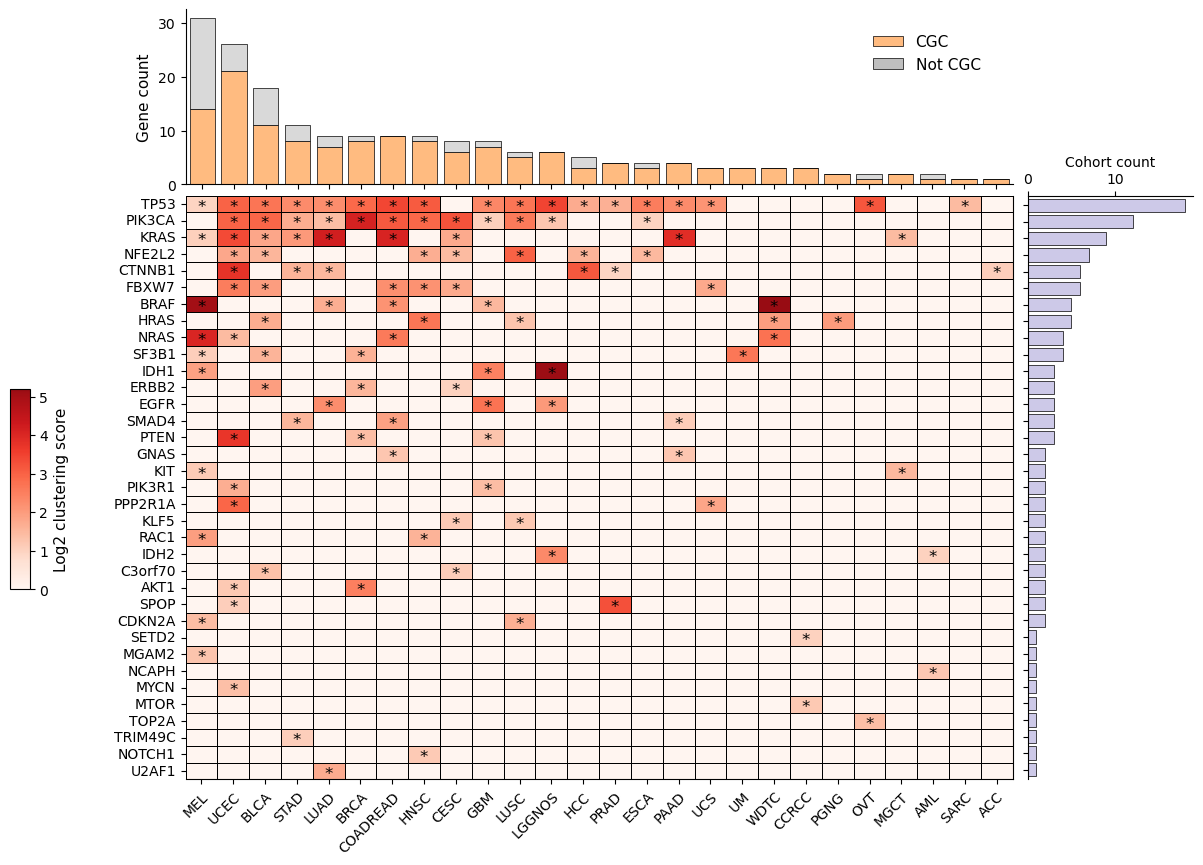

In [916]:
top_cohorts_n=None
top_genes_n=35

o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_subset, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_subset, 
                                                                                 cohort_df, 
                                                                                 top_cohorts_n=top_cohorts_n, 
                                                                                 top_genes_n=top_genes_n, 
                                                                                 anomaly_dict=False)

df_anomaly.columns = [cohort.split("_")[2] for cohort in df_anomaly.columns]
gene_colors, lut = get_gene_annotation(df_binary, genetable)

plot_landscape(df=df_binary, 
               gene_colors=gene_colors, 
               gene_hits_count=gene_hits_count, 
               cohort_hits_count=cohort_hits_count,
               lut=lut, 
               df_anomaly=df_anomaly,
               figsize=(13,10),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-0.2, 1.3),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.03,
               filename="landscape_heatmap_tcga.png")

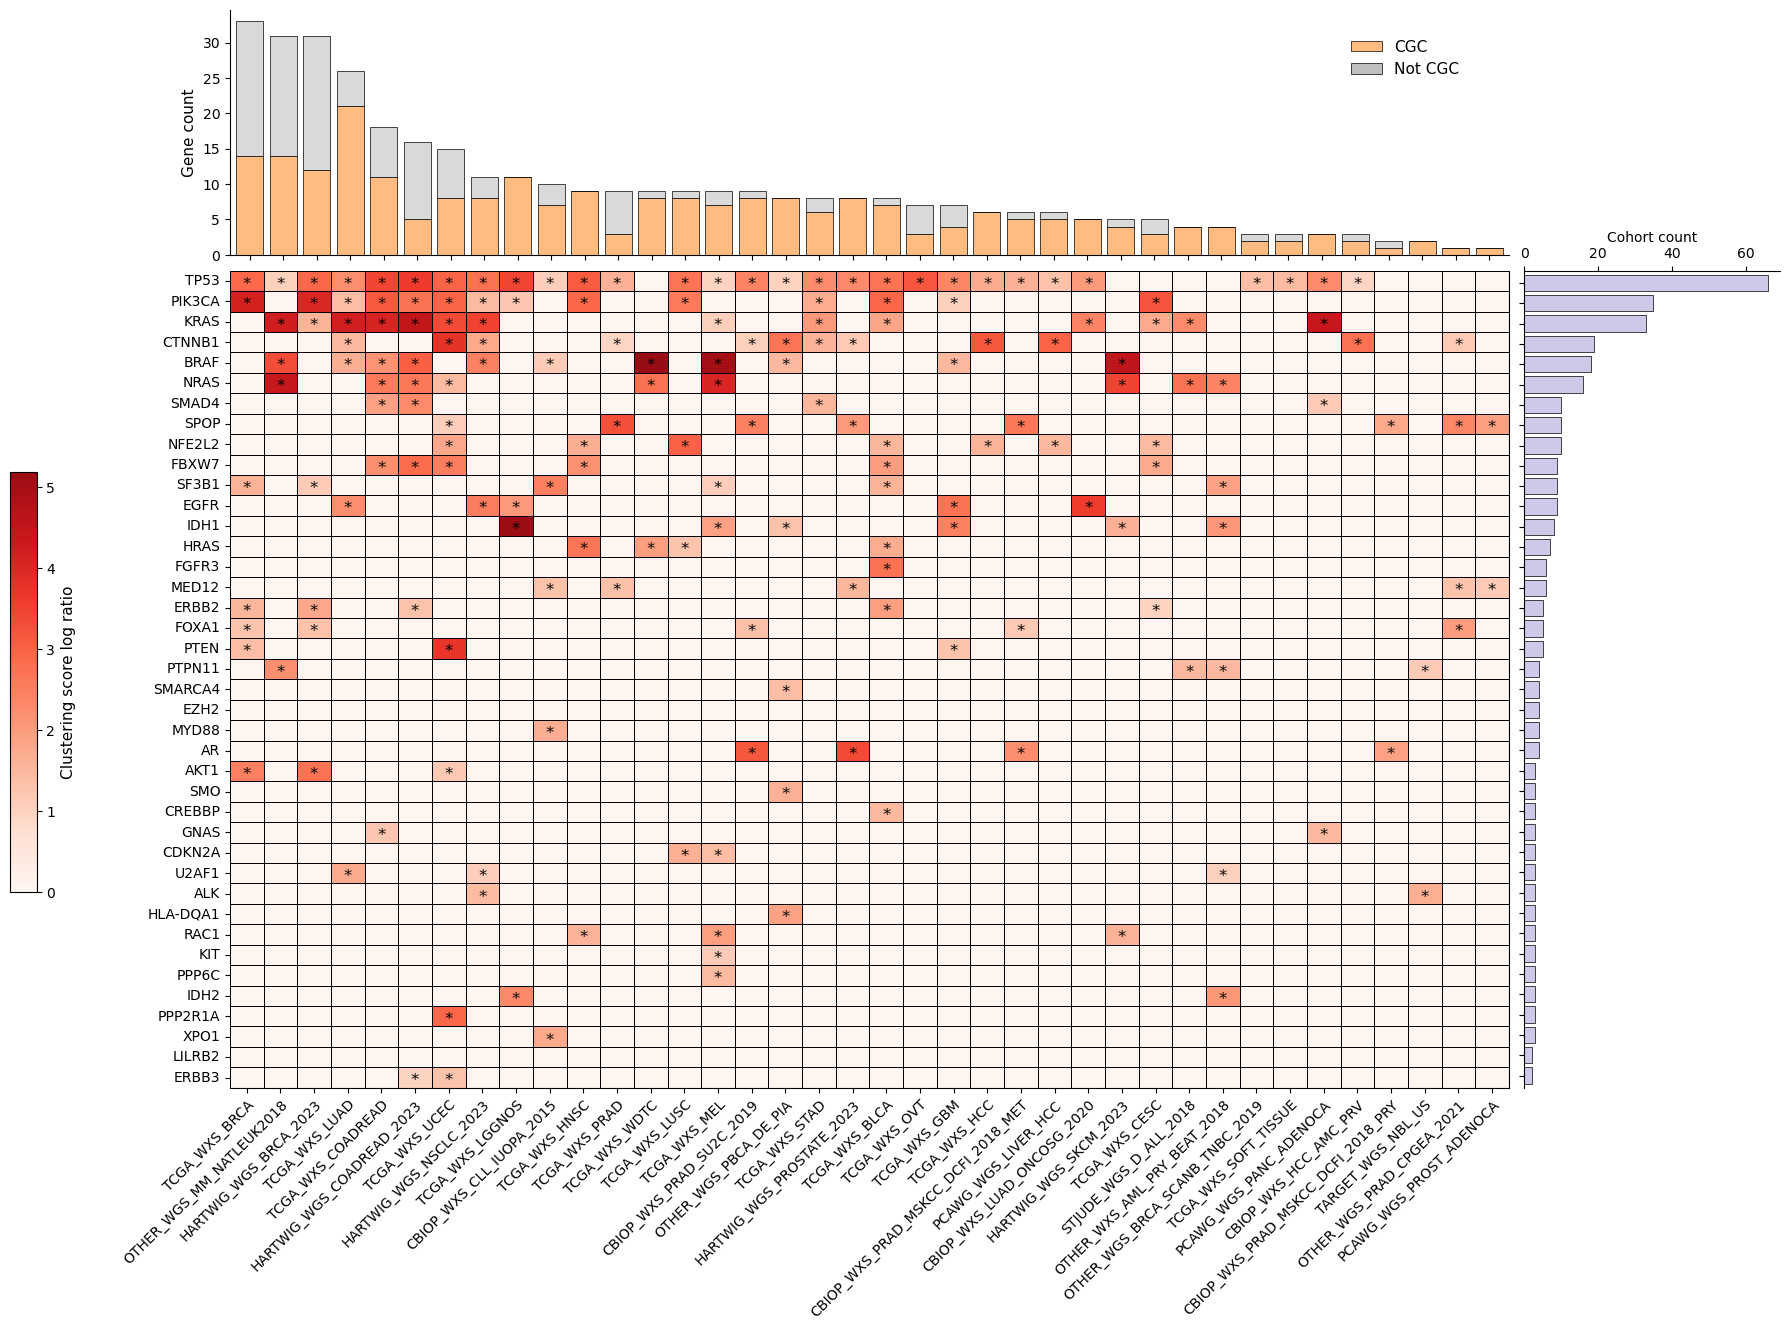

In [335]:
top_cohorts_n=40
top_genes_n=40 

o3d_output = get_anomaly_df(genetable, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=False)

gene_colors, lut = get_gene_annotation(df_binary, genetable)

plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=df_anomaly,
               gene_hits_count=gene_hits_count, cohort_hits_count=cohort_hits_count,
               figsize=(20,14),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-0.2, 1.3),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.02, 
               hspace=0.03,
               cbar_loc=[0.015, 0.25, 0.0133, .3],
               filename="landscape_heatmap_all_cohorts.png")

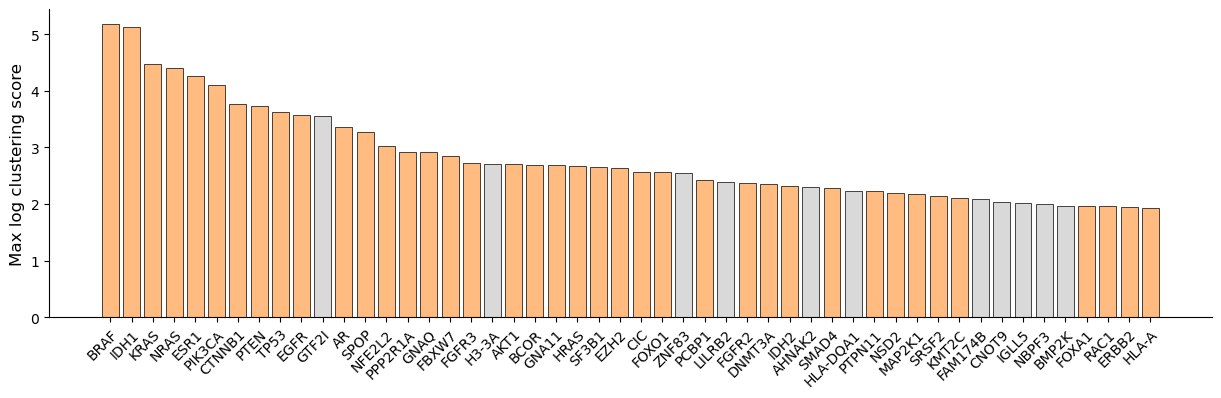

In [806]:
# Genes by score (only last two are not detected in IntOGen)

# https://ijgc.bmj.com/content/ijgc/33/Suppl_3/A25.full.pdf
# https://aacrjournals.org/cancerres/article/84/7_Supplement/LB014/742373

# Data
df = o3d_output.groupby("Gene").apply(lambda x: max(x.Clustering_score)).sort_values(ascending=False).reset_index()
df.columns = "Gene", "Score"
df = df.merge(o3d_output[["Gene", "CGC"]].drop_duplicates(), how="left", on="Gene")
df["CGC"] = df.apply(lambda x: "CGC" if x.CGC == 1 else "Not CGC", axis=1)
df = df.sort_values("Score", ascending=False)[:50]#.set_index("Gene")

# Plot
color_map = {"CGC": "#ffbb80", "Not CGC": "#d9d9d9"}
bar_colors = df["CGC"].map(color_map)

fig, ax = plt.subplots(figsize=(15, 4))
bars = ax.bar(df["Gene"], df["Score"], color=bar_colors, edgecolor='black', lw=0.5)
plt.xticks(rotation=45, rotation_mode="anchor", ha='right') 

ax.set_ylabel('Max log clustering score', fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [472]:
df_complete = o3d_output.groupby("Gene").apply(
    lambda x: x.sort_values("Clustering_score", ascending=False).iloc[0]).sort_values("Clustering_score", ascending=False)
df_complete[:30]

,Cohort,Gene,Uniprot_ID,qval,C_gene,C_pos,Clustering_score,CGC,Fish
Gene,,,,,,,,,
BRAF,TCGA_WXS_WDTC,BRAF,P15056,0.0,1.0,[601 600],179.618281,1,0
IDH1,TCGA_WXS_LGGNOS,IDH1,A0A024R3Y6,0.0,1.0,[132],170.296501,1,0
KRAS,HARTWIG_WGS_COADREAD_2023,KRAS,A0A024RAV5,0.0,1.0,[ 12 60 13 14 61 34 117],88.347831,1,0
NRAS,OTHER_WGS_MM_NATLEUK2018,NRAS,P01111,0.0,1.0,[12 13 61 59 62 64 86],81.875684,1,0
ESR1,HARTWIG_WGS_BRCA_2023,ESR1,G4XH65,0.0,1.0,[536 538 537 532],70.640336,1,0
PIK3CA,TCGA_WXS_BRCA,PIK3CA,P42336,0.0,1.0,[1049 1047 1044 1043 545 542 546 539 345 ...,60.347787,1,0
CTNNB1,TCGA_WXS_UCEC,CTNNB1,A0A024R2Q3,0.0,1.0,[35 34 33 32 37 41],43.402745,1,0
PTEN,TCGA_WXS_UCEC,PTEN,F6KD01,0.0,1.0,[132 130 124 129 127 128 126 125 123 92 93 1...,41.634486,1,0
TP53,HARTWIG_WGS_COADREAD_2023,TP53,K7PPA8,0.0,1.0,[239 240 273 245 242 246 241 274 236 248 194 2...,37.386387,1,0


In [477]:
o3d_output[o3d_output["Gene"] == "ZNF83"]

,Cohort,Gene,Uniprot_ID,qval,C_gene,C_pos,Clustering_score,CGC,Fish
17443,CBIOP_WXS_BLCA_BGI,ZNF83,P51522,0.0000,1.0,[293 290],12.892111,0,0
26444,CBIOP_WXS_SCLC_UCOLOGNE_2015,ZNF83,P51522,0.4982,0.0,[280 281],3.046575,0,0
30109,OTHER_WGS_DLBCL_NATCOM_2018,ZNF83,P51522,1.0000,0.0,NaN,1.377934,0,0


In [476]:
o3d_output[o3d_output["Gene"] == "LILRB2"]

,Cohort,Gene,Uniprot_ID,qval,C_gene,C_pos,Clustering_score,CGC,Fish
19044,CGCI_WGS_CESC_2020,LILRB2,Q8N423,0.0,1.0,[374 373 372 371 375],10.958535,0,0
19489,CBIOP_WXS_ACY_2019,LILRB2,Q8N423,1.0,0.0,NaN,1.630882,0,0
25265,CBIOP_WXS_LUAD_BROAD,LILRB2,Q8N423,1.0,0.0,NaN,0.924623,0,0
25759,CGCI_WGS_BL_2020,LILRB2,Q8N423,0.0,1.0,[374 373 372 371 375],9.612547,0,0


# Down here

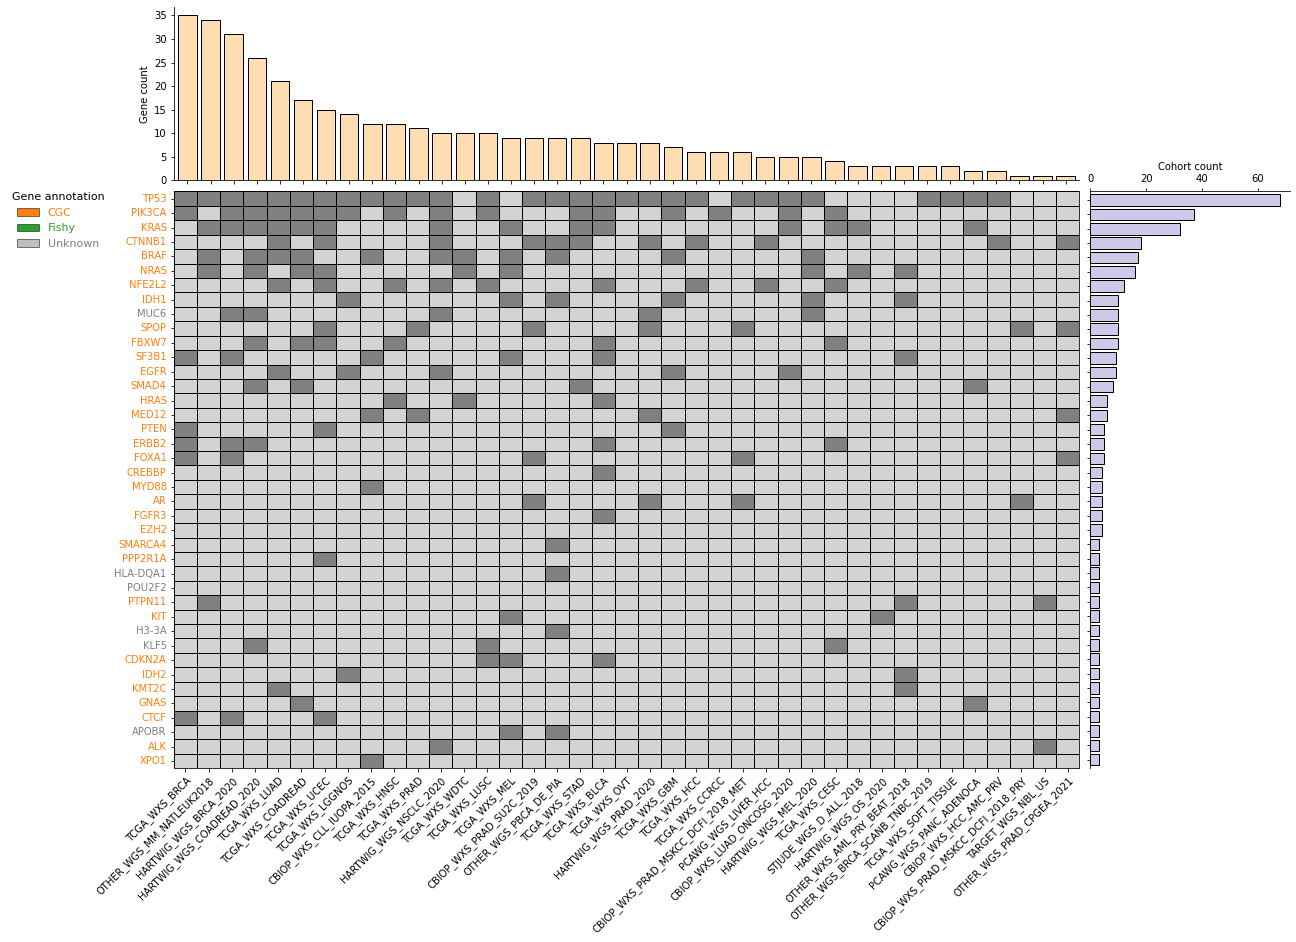

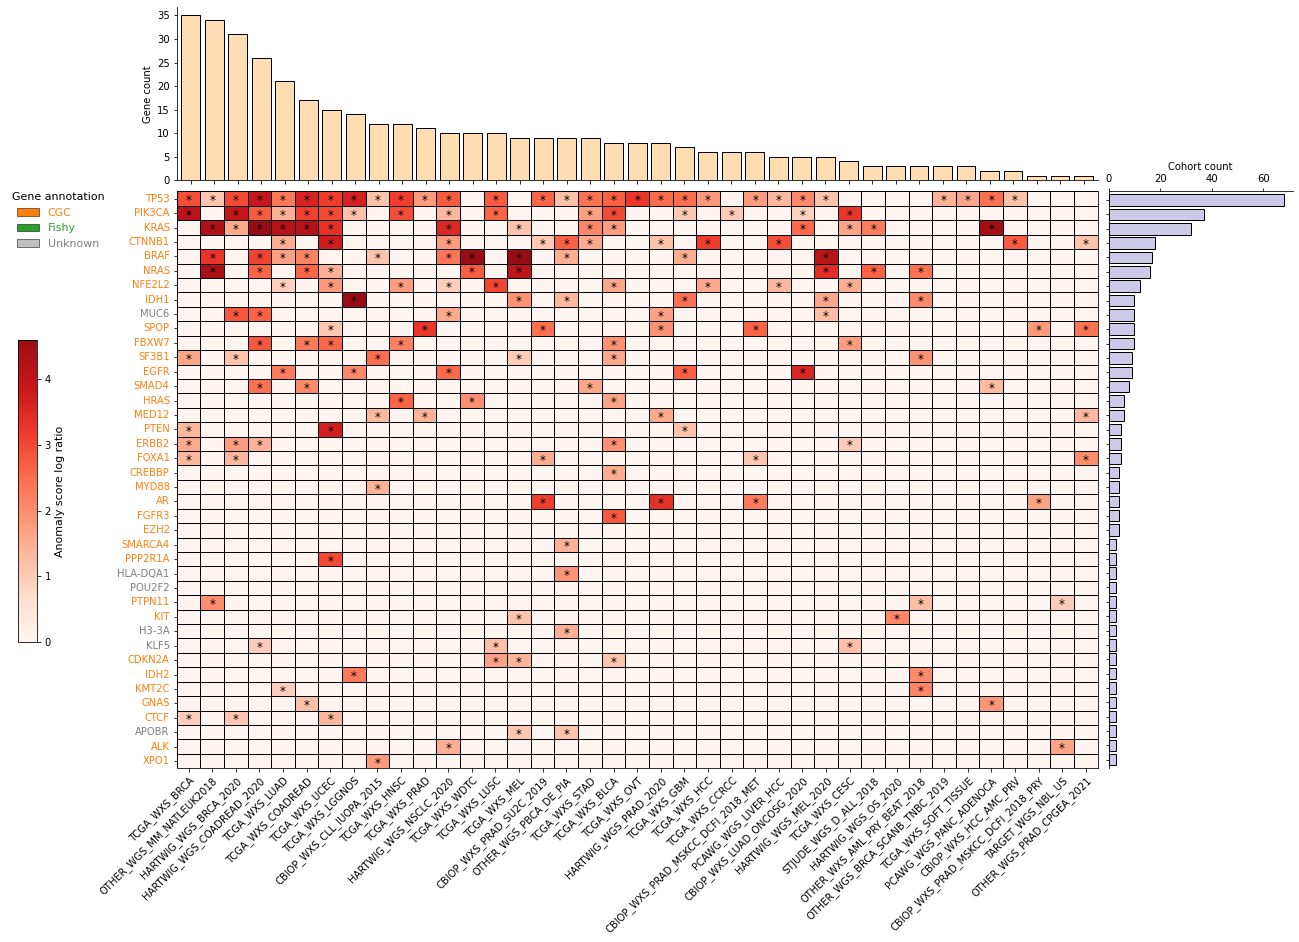

In [13]:
top_cohorts_n=40
top_genes_n=40

o3d_output = get_anomaly_df(genetable, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=False)

gene_colors, lut = get_gene_annotation(df_binary, genetable)

plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=None,
               gene_hits_count=gene_hits_count, cohort_hits_count=cohort_hits_count,
               figsize=(20,14),
               width_ratios=[1, 0.22],
               height_ratios=[0.3, 1],
               legend_box=(-4.9, 1.0156),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.02, 
               hspace=0.03)

plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=df_anomaly,
               gene_hits_count=gene_hits_count, cohort_hits_count=cohort_hits_count,
               figsize=(20,14),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-5.4, 1.0156),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.02, 
               hspace=0.03,
               cbar_loc=[0.015, 0.25, 0.0133, .3],
               filename="landscape_heatmap_all_cohorts.png")

In [18]:
df_binary.loc[df_binary["OTHER_WGS_PBCA_DE_PIA"] == 1, "OTHER_WGS_PBCA_DE_PIA"]

Gene
TP53        1
CTNNB1      1
BRAF        1
IDH1        1
SMARCA4     1
HLA-DQA1    1
H3-3A       1
APOBR       1
Name: OTHER_WGS_PBCA_DE_PIA, dtype: int64

In [25]:
genetable[(genetable["Gene"] == "IGLL5") & (genetable["o3d_qval"] < 0.01)]

,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
2428964,IGLL5,B9A064,Processed,0,0,2.0,0.0,0.0,17734.0,1.000000,...,0.077143,0.223067,7975.0,1.00000,1.0,NaN,NaN,NaN,DLBCLNOS,OTHER_WGS_DLBCL_NATCOM_2018
2642228,IGLL5,B9A064,Processed,0,0,4.0,0.0,0.0,11225.0,0.626789,...,0.556394,0.592594,15605.0,0.99999,1.0,NaN,NaN,NaN,PCM,OTHER_WGS_MM_NATLEUK2018


## Non annotated genes

In [499]:
intogen_df = pd.read_csv("/workspace/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/intogen_output/drivers.tsv", sep="\t")
intogen_genes = intogen_df.SYMBOL.unique()

In [500]:
def get_intogen_annotation(df, intogen_genes):
    
    gene_annotation = ["Detected" if gene in intogen_genes else "Not detected" for gene in df.index]
    gene_annotation = pd.Series(gene_annotation, name="Annotation")
    lut = {"Detected": '#4d4dff', 
           "Not detected": '#b30000'}
    gene_colors = gene_annotation.map(lut)
    
    return gene_colors, lut


def get_intogen_genes_by_cohort(df_binary, intogen_df):

    df = pd.DataFrame(0, index=df_binary.index, columns=df_binary.columns)
    for gene in df.index:
        for cohort in df.columns:
            if len(intogen_df[(intogen_df["SYMBOL"] == gene) & (intogen_df["COHORT"] == cohort)]) > 0:
                df.loc[gene, cohort] = 1
                
    return df

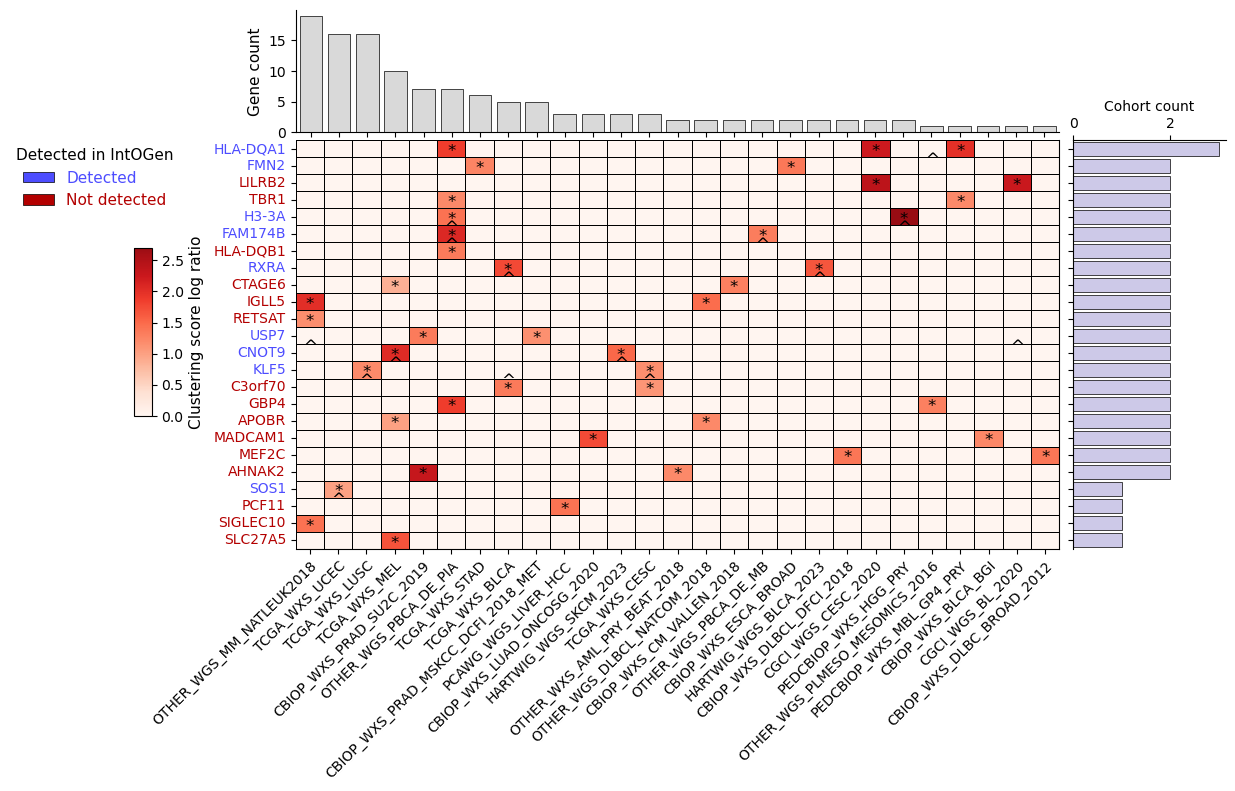

In [525]:
genetable_not_annot = genetable[(genetable["CGC"] == 0) & (genetable["Fish"] == 0)].reset_index(drop=True)
top_cohorts_n=150
top_genes_n=24

o3d_output = get_anomaly_df(genetable_not_annot, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

df_anomaly, _, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_not_annot, 
                                                      cohort_df, 
                                                      top_cohorts_n=top_cohorts_n, 
                                                      top_genes_n=top_genes_n, 
                                                      anomaly_dict=anomaly_dict)

df_binary, _, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(genetable_not_annot, 
                                                      cohort_df, 
                                                      top_cohorts_n=top_cohorts_n, 
                                                      top_genes_n=top_genes_n, 
                                                      anomaly_dict=False)

gene_colors, lut = get_intogen_annotation(df_binary, intogen_genes)
intogen_gene_by_cohort = get_intogen_genes_by_cohort(df_binary, intogen_df)

plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=df_anomaly,
               gene_hits_count=gene_hits_count, cohort_hits_count=cohort_hits_count,
               figsize=(12,7),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-5.8, 1.0156),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.03,
               cbar_loc=[-0.01, 0.3, 0.015, .24],
               intogen_label=True,
               intogen_label_table=intogen_gene_by_cohort,
               color_gene=True)

## Clustering score density plots

### TCGA

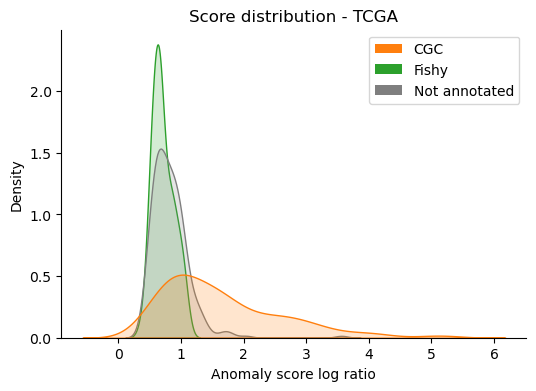

In [562]:
gene_colors, lut = get_gene_annotation(df_binary, genetable_subset)

# Get df with scores
o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output["Annotation"] = o3d_output.apply(lambda x: "CGC" if x["CGC"] == 1 else "Fishy" if x["Fish"] == 1 else "Not annotated", axis=1)

## Plot 
plt.figure(figsize=(6, 4))
palette = {'CGC': lut["CGC"], 'Fishy': lut["Fishy"], 'Not annotated': lut["Not annotated"]}
sns.kdeplot(data=o3d_output, x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Anomaly score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - TCGA", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["CGC"], label="CGC"),
           mpatches.Patch(facecolor=lut["Fishy"], label="Fishy"),
           mpatches.Patch(facecolor=lut["Not annotated"], label="Not annotated")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.savefig("score_distribution_tcga.png", dpi=300, bbox_inches='tight')
plt.show()

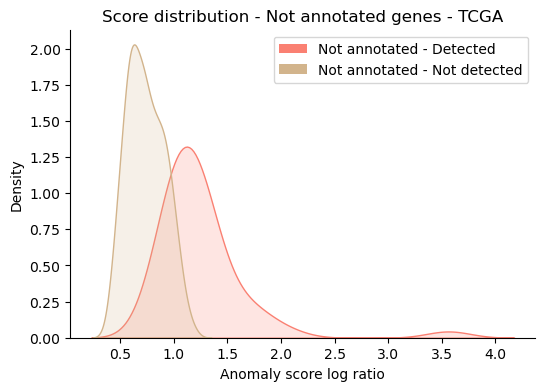

In [563]:
# Get df with scores
o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[(o3d_output["CGC"] == 0) & (o3d_output["Fish"] == 0)]
o3d_output["Annotation"] = o3d_output["C_gene"]
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)

## Plot 
plt.figure(figsize=(6, 4))
palette = {1: "salmon", 0: "tan"}
sns.kdeplot(data=o3d_output, x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Anomaly score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - Not annotated genes - TCGA", fontsize=12)

handles = [mpatches.Patch(facecolor="salmon", label="Not annotated - Detected"),
           mpatches.Patch(facecolor="tan", label="Not annotated - Not detected")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.savefig("score_distribution_Not annotated_tcga.png", dpi=300, bbox_inches='tight')
plt.show()

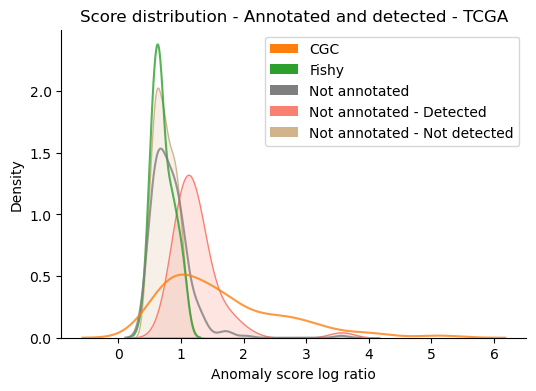

In [564]:
# Get df with scores with annotations
o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output2 = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output2["Annotation"] = o3d_output2.apply(lambda x: "CGC" if x["CGC"] == 1 else "Fishy" if x["Fish"] == 1 else "Not annotated", axis=1)

# Get df with scores of not annotated genes
o3d_output = get_anomaly_df(genetable_subset, o3d_output_dir)
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[(o3d_output["CGC"] == 0) & (o3d_output["Fish"] == 0)]
o3d_output["Annotation"] = o3d_output["C_gene"]
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output["Annotation"] = o3d_output["Annotation"].map({1 : "Not annotated - Detected", 0 : "Not annotated - Not detected"})

# Concat
o3d_output = pd.concat((o3d_output, o3d_output2)).reset_index(drop=True)


## Plot 
plt.figure(figsize=(6, 4))
palette = {'CGC': lut["CGC"], 'Fishy': lut["Fishy"], 'Not annotated': lut["Not annotated"], "Not annotated - Detected" : "salmon", "Not annotated - Not detected" : "tan"}
annotation_ix = (o3d_output["Annotation"] == "CGC") | (o3d_output["Annotation"] == "Fishy") | (o3d_output["Annotation"] == "Not annotated")
sns.kdeplot(data=o3d_output[~annotation_ix], x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)
sns.kdeplot(data=o3d_output[annotation_ix], x='Clustering_score', hue='Annotation', fill=False, common_norm=False, palette=palette, alpha=0.8)

# Add labels and a legend
plt.xlabel('Anomaly score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - Annotated and detected - TCGA", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["CGC"], label="CGC"),
           mpatches.Patch(facecolor=lut["Fishy"], label="Fishy"),
           mpatches.Patch(facecolor=lut["Not annotated"], label="Not annotated"),
           mpatches.Patch(facecolor="salmon", label="Not annotated - Detected"),
           mpatches.Patch(facecolor="tan", label="Not annotated - Not detected")]
plt.legend(handles=handles)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.savefig("score_distribution_annotated_detected_tcga.png", dpi=300, bbox_inches='tight')
plt.show()

### All cohorts

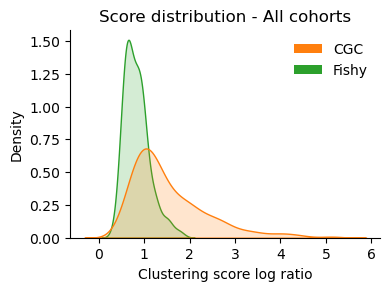

In [787]:
## Score distribution - CGC & Fishy - All cohorts

gene_colors, lut = get_gene_annotation(df_binary, genetable)

# Get df with scores
o3d_output = get_anomaly_df(genetable, o3d_output_dir)
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output["Annotation"] = o3d_output.apply(lambda x: "CGC" if x["CGC"] == 1 else "Fishy" if x["Fish"] == 1 else "Not annotated", axis=1)
o3d_output = o3d_output[o3d_output["Annotation"] != "Not annotated"]

# Plot
plt.figure(figsize=(4, 2.7))
palette = {'CGC': lut["CGC"], 'Fishy': lut["Fishy"], 'Not annotated': lut["Not annotated"]}
sns.kdeplot(data=o3d_output, x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Clustering score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - All cohorts", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["CGC"], label="CGC"),
           mpatches.Patch(facecolor=lut["Fishy"], label="Fishy"),]
           #mpatches.Patch(facecolor=lut["Not annotated"], label="Not annotated")]
plt.legend(handles=handles, frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.savefig("score_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/jobs/spellegrini/9964934/ipykernel_1413/3261778281.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o3d_output_noannot["Annotation"] = o3d_output_noannot["C_gene"]


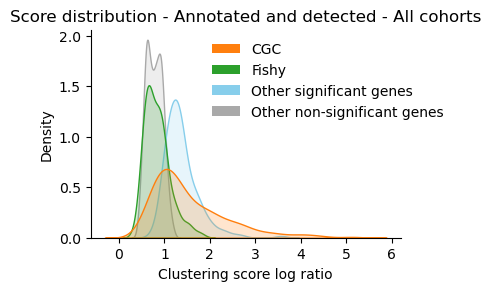

In [788]:
## Score distribution - Annotated and detected - All cohorts

# Get df with scores with annotations
o3d_output = get_anomaly_df(genetable, o3d_output_dir)
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])

o3d_output_annot = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output_annot["Annotation"] = o3d_output_annot.apply(lambda x: "CGC" if x["CGC"] == 1 else "Fishy" if x["Fish"] == 1 else "Not annotated", axis=1)
o3d_output_annot = o3d_output_annot[o3d_output_annot["Annotation"] != "Not annotated"]

# Get df with scores of not annotated genes
o3d_output_noannot = o3d_output[(o3d_output["CGC"] == 0) & (o3d_output["Fish"] == 0)]
o3d_output_noannot["Annotation"] = o3d_output_noannot["C_gene"]
o3d_output_noannot = o3d_output_noannot[o3d_output_noannot["qval"] < 1].reset_index(drop=True)
o3d_output_noannot["Annotation"] = o3d_output_noannot["Annotation"].map({1 : "Other significant genes", 0 : "Other non significant genes"})

o3d_output2 = pd.concat((o3d_output_annot, o3d_output_noannot)).reset_index(drop=True)


## Plot 
plt.figure(figsize=(4, 2.7))
palette = {'CGC': lut["CGC"], 'Fishy': lut["Fishy"], "Other significant genes" : "skyblue", "Other non significant genes" : "darkgray"}
# annotation_ix = (o3d_output["Annotation"] == "CGC") | (o3d_output["Annotation"] == "Fishy") | (o3d_output["Annotation"] == "Not annotated")
sns.kdeplot(data=o3d_output2, x='Clustering_score', hue='Annotation', fill=True, common_norm=False, palette=palette, alpha=0.2)
# sns.kdeplot(data=o3d_output[annotation_ix], x='Clustering_score', hue='Annotation', fill=False, common_norm=False, palette=palette, alpha=0.8)

# Add labels and a legend
plt.xlabel('Clustering score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - Annotated and detected - All cohorts", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["CGC"], label="CGC"),
           mpatches.Patch(facecolor=lut["Fishy"], label="Fishy"),
           mpatches.Patch(facecolor="skyblue", label="Other significant genes"),
           mpatches.Patch(facecolor="darkgray", label="Other non-significant genes")]
plt.legend(handles=handles, bbox_to_anchor=[0,0,1.18,1], frameon=False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.savefig("score_distribution_annotated_detected.png", dpi=300, bbox_inches='tight')
plt.show()

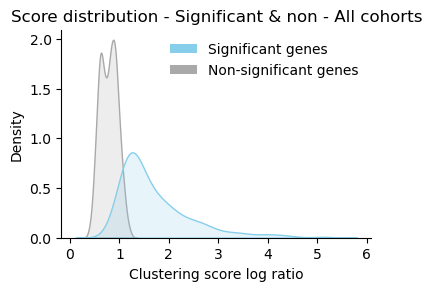

In [793]:
## Score distribution - Significant & non-significant - All cohorts

gene_colors, lut = get_gene_annotation(df_binary, genetable)

# Get df with scores
o3d_output = get_anomaly_df(genetable, o3d_output_dir)
o3d_output["Clustering_score"] = np.log(o3d_output["Clustering_score"])
o3d_output = o3d_output[o3d_output["qval"] < 1].reset_index(drop=True)
o3d_output["C_gene"] = o3d_output["C_gene"].map({1 : "Significant", 0 : "Non-significant"})

# Plot
plt.figure(figsize=(4, 2.7))
palette = {'Significant': "skyblue", 'Non-significant': "darkgray"}
sns.kdeplot(data=o3d_output, x='Clustering_score', hue='C_gene', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Clustering score log ratio')
plt.ylabel('Density')
plt.title("Score distribution - Significant & non - All cohorts", fontsize=12)

handles = [mpatches.Patch(facecolor="skyblue", label="Significant genes"),
           mpatches.Patch(facecolor="darkgray", label="Non-significant genes"),]
           #mpatches.Patch(facecolor=lut["Not annotated"], label="Not annotated")]
plt.legend(handles=handles, frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.savefig("score_distribution_significant_nonsignificant.png", dpi=300, bbox_inches='tight')
plt.show()

## Highlight some interesting cases

In [369]:
def int_lst_from_str(str_lst):
    
    numbers = re.findall(r'\d+', str_lst)
    
    return np.array([int(num) for num in numbers])


def get_pos_clust_freq(gene_df, pos):

    tot_count = len(gene_df)
    count = sum([pos in gene_df.iloc[i].C_pos for i in range(tot_count)])
    
    return count / tot_count


def get_gene_clust_conservation(anomaly_df, gene):
    
    # Get df with cluster pos as list
    df = anomaly_df.copy()
    df = df[df["C_gene"] == 1]
    df = df[df["Gene"] == gene]
    df["C_pos"] = df.apply(lambda x: int_lst_from_str(x["C_pos"]), axis=1)
    
    # Get conservation of each cluster pos
    cluster_pos = np.sort(np.unique(np.concatenate(df["C_pos"].values)))
    final_df = pd.DataFrame({"Pos" : cluster_pos})
    print("Cohorts:", len(df))
    final_df["clusters_conservation"] = final_df.apply(lambda x: get_pos_clust_freq(df, x["Pos"]), axis=1)
    
    return final_df


def write_defattr_file(file_path, gene, uni_id, df, attr_name="clusters_conservation"):

    header = f"""#
#  Cluster conservation for {uni_id} ({gene})
#
#  Use this file to assign the attribute in Chimera with the 
#  Define Attribute tool or the command defattr.
#"""

    with open(file_path, "w") as file:
        # Write the data to the file
        file.write(header)

    with open(file_path, "a") as file:
        file.write(f"\nattribute: {attr_name}")
        file.write("\nrecipient: residues")

        for res, attr in zip(df["Pos"], df[attr_name]):
            file.write('\n\t:' + str(res) + '\t' + str(attr))

In [370]:
gene = "IDH1"
df = get_anomaly_df(genetable, o3d_output_dir)

uni_id = df[df["Gene"] == gene].Uniprot_ID.unique()[0]
print("\n>", gene, uni_id)
gene_conservation = get_gene_clust_conservation(df, gene)
gene_conservation["Pos"].values


> IDH1 O75874
Cohorts: 10


array([132])

In [1503]:
gene_conservation

,Pos,Conservation
0,132,1.0


In [371]:
for gene in ["PIK3CA", "MUC6", "BRAF", "KRAS", "TP53", "CTNNB1", "EGFR", "NFE2L2", "MUC6"]:

    df = get_anomaly_df(genetable, o3d_output_dir)

    uni_id = df[df["Gene"] == gene].Uniprot_ID.unique()[0]
    print("\n>", gene, uni_id)
    gene_conservation = get_gene_clust_conservation(df, gene)
    display(gene_conservation)

    file_path = f"{gene}_clusters_conservation.defattr"
    write_defattr_file(file_path, gene, uni_id, gene_conservation)


> PIK3CA P42336
Cohorts: 37


,Pos,clusters_conservation
0,9,0.027027
1,38,0.108108
2,39,0.054054
3,69,0.027027
4,81,0.054054
5,83,0.027027
6,88,0.108108
7,90,0.027027
8,93,0.108108
9,104,0.054054



> MUC6 Q6W4X9
Cohorts: 10


,Pos,clusters_conservation
0,213,1.0



> BRAF P15056
Cohorts: 17


,Pos,clusters_conservation
0,464,0.058824
1,466,0.117647
2,469,0.117647
3,501,0.117647
4,574,0.117647
5,581,0.176471
6,594,0.470588
7,596,0.176471
8,597,0.411765
9,600,1.000000



> KRAS P01116
Cohorts: 32


,Pos,clusters_conservation
0,12,1.00000
1,13,0.84375
2,14,0.09375
3,16,0.03125
4,18,0.06250
5,19,0.09375
6,22,0.03125
7,34,0.09375
8,58,0.03125
9,59,0.18750



> TP53 P04637
Cohorts: 68


,Pos,clusters_conservation
0,95,0.014706
1,105,0.132353
2,106,0.044118
3,107,0.058824
4,109,0.044118
...,...,...
131,287,0.044118
132,289,0.014706
133,331,0.014706
134,334,0.029412



> CTNNB1 P35222
Cohorts: 18


,Pos,clusters_conservation
0,29,0.055556
1,31,0.055556
2,32,0.888889
3,33,0.888889
4,34,0.944444
5,35,0.222222
6,36,0.222222
7,37,0.777778
8,41,0.333333
9,45,0.277778



> EGFR P00533
Cohorts: 9


,Pos,clusters_conservation
0,62,0.222222
1,63,0.111111
2,84,0.222222
3,108,0.444444
4,252,0.222222
5,254,0.111111
6,256,0.222222
7,263,0.333333
8,270,0.111111
9,289,0.444444



> NFE2L2 Q16236
Cohorts: 12


,Pos,clusters_conservation
0,24,0.583333
1,26,0.250000
2,27,0.166667
3,28,0.166667
4,29,0.666667
5,30,0.250000
6,31,0.583333
7,32,0.083333
8,34,0.500000
9,77,0.416667



> MUC6 Q6W4X9
Cohorts: 10


,Pos,clusters_conservation
0,213,1.0


In [1475]:
!ls

BRAF_clusters_conservation.defattr    landscape.ipynb
CTNNB1_clusters_conservation.defattr  NFE2L2_clusters_conservation.defattr
EGFR_clusters_conservation.defattr    TP53_clusters_conservation.defattr
KRAS_clusters_conservation.defattr    tp53_clusters_conservation_tcga.defattr


In [1478]:
!cat TP53_clusters_conservation.defattr | head

#
#  Cluster conservation for P04637 (TP53)
#
#  Use this file to assign the attribute in Chimera with the 
#  Define Attribute tool or the command defattr.
#
attribute: clusters_conservation
recipient: residues
	:95	0.014705882352941176
	:105	0.1323529411764706


## Show clusters in one protein-tissue

In [13]:
gene = "CTNNB1"
df = get_anomaly_df(genetable, o3d_output_dir)

uni_id = df[df["Gene"] == gene].Uniprot_ID.unique()[0]
print("\n>", gene, uni_id)
gene_conservation = get_gene_clust_conservation(df, gene)
gene_conservation["Pos"].values


> CTNNB1 P35222
Cohorts: 18


array([ 29,  31,  32,  33,  34,  35,  36,  37,  41,  45, 333, 335])

In [22]:
df[(df["Cohort"] == "TCGA_WXS_STAD") & (df["Gene"] == "CTNNB1")]

,Cohort,Gene,Uniprot_ID,qval,C_gene,C_pos,Anomaly_score,CGC,Fish
61111,TCGA_WXS_STAD,CTNNB1,P35222,0.0,1.0,[34 32 33 37],4.839807,1,0


In [39]:
df = pd.read_csv(f"{o3d_output_dir}/TCGA_WXS_STAD.3d_clustering_pos.csv")
df = df[df["Gene"] == "CTNNB1"].iloc[:,:15]
df

,Gene,Uniprot_ID,F,Pos,Mut_in_gene,Mut_in_res,Mut_in_vol,Obs_anomaly,Ratio_obs_sim,pval,C,C_ext,Cluster,Rank,Tot_samples
2480,CTNNB1,P35222,1,34,15,3,10,0.553665,4.839807,0.0000,1,0.0,0.0,0,13
2481,CTNNB1,P35222,1,32,15,2,6,0.282225,2.723132,0.0000,1,0.0,0.0,1,13
2482,CTNNB1,P35222,1,33,15,1,6,0.282217,2.914884,0.0000,1,0.0,0.0,2,13
2483,CTNNB1,P35222,1,37,15,4,4,0.168252,1.832283,0.0023,1,0.0,1.0,3,13
2484,CTNNB1,P35222,1,84,15,1,1,0.025071,0.284954,1.0000,0,NaN,NaN,4,13
2485,CTNNB1,P35222,1,339,15,1,1,0.021566,0.255591,1.0000,0,NaN,NaN,5,13
2486,CTNNB1,P35222,1,123,15,1,1,0.021445,0.264853,1.0000,0,NaN,NaN,6,13
2487,CTNNB1,P35222,1,575,15,1,1,0.018637,0.238560,1.0000,0,NaN,NaN,7,13
2488,CTNNB1,P35222,1,622,15,1,1,0.018302,0.242417,1.0000,0,NaN,NaN,8,13


In [48]:
df_attr = df[["Pos", "Ratio_obs_sim"]].reset_index(drop=True)
df_attr["Ratio_obs_sim"] = np.log(df_attr["Ratio_obs_sim"])
df_attr = df_attr.rename(columns={"Ratio_obs_sim" : "log_ratio_obs_sim"})
df_attr

,Pos,log_ratio_obs_sim
0,34,1.576875
1,32,1.001783
2,33,1.069830
3,37,0.605563
4,84,-1.255427
5,339,-1.364177
6,123,-1.328581
7,575,-1.433134
8,622,-1.417094


In [49]:
file_path = f"ctnnb1_log_ratio_obs_sim.defattr"
write_defattr_file(file_path, gene, uni_id, df_attr, "log_ratio_obs_sim")

# CH

In [263]:
def plot_landscape(df, gene_colors, lut, 
                   df_anomaly=None,
                   figsize=(16,14),
                   width_ratios=[1, 0.2],
                   height_ratios=[0.3, 1],
                   legend_box=(-5.5, 1.02),
                   ax1_margin=0.005,
                   ax4_margin=0.005,
                   wspace=0.02, 
                   hspace=0.05,
                   cbar_loc=[-0.01, 0.2, 0.02, .3],
                   filename="landscape_heatmap_tcga.png"):
    
    if df_anomaly is not None:
        df_binary = df
        df = df_anomaly
        cmap = "OrRd"
        cmap = create_custom_colormap()
    else:
        colors = ["lightgray", "gray"] 
        cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

    # Define the row and column labels
    row_labels = df.index
    col_labels = df.columns
    #col_labels = [ctype_dict[cohort] for cohort  in col_labels]

    gene_sums = gene_hits_count["Oncodrive3D"].values
    cohort_sums = cohort_hits_count["Oncodrive3D"].values

    # Create a figure with a grid layout for heatmap and bars
    fig, ax = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})
    ax1 = ax[0,0]
    ax2 = ax[0,1]
    ax3 = ax[1,0]
    ax4 = ax[1,1]

    # Create the heatmap
    sns.heatmap(df, annot=False, cmap=cmap, cbar=False, xticklabels=col_labels, yticklabels=row_labels, ax=ax3, lw=1, linecolor="black")
    ax3.set_xticklabels(col_labels, rotation=45, rotation_mode="anchor", ha='right') 
    ax3.set_xlabel("Cohort")
    ax3.set_ylabel("Gene")
    ax3.set_xlabel("")
    ax3.set_ylabel("")
    ax3.spines['bottom'].set_visible(True)
    ax3.spines['right'].set_visible(True)
    for i, label in enumerate(ax3.get_yticklabels()):
        label.set_color(gene_colors[i])

    # Add bars for the top axis
    ax4.barh(np.arange(len(gene_sums)), gene_sums, color='#cdc9e8', edgecolor="black")
    ax4.set_yticks(np.arange(len(gene_sums)))
    ax4.set_yticklabels([])
    ax4.set_xlabel("Cohort count")
    ax4.invert_yaxis()

    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')
    ax4.spines['bottom'].set_visible(False)
    ax4.spines['right'].set_visible(False)

    # Add bars for the right axis
    row_sums = np.sum(df, axis=1)
    ax1.bar(np.arange(len(cohort_sums)), cohort_sums, color='#ffddb3', edgecolor="black")
    ax1.set_xticks(np.arange(len(cohort_sums)))
    ax1.set_ylabel("Gene count")
    ax1.set_xticklabels([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Details
    ax2.remove()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    ax1.margins(x=ax1_margin, tight=True)
    ax4.margins(y=ax4_margin, tight=True)

    handles, labels = ax3.get_legend_handles_labels()
    handles.append(mpatches.Patch(facecolor=lut["CGC"], edgecolor="black", label='CGC', lw=0.5))
    handles.append(mpatches.Patch(facecolor=lut["Fishy"], edgecolor="black", label="Fishy", lw=0.5))
    handles.append(mpatches.Patch(facecolor="#bfbfbf", edgecolor="black", label="Not annotated", lw=0.5))
    legend = plt.legend(handles=handles, bbox_to_anchor=legend_box, frameon=False, 
                        title="Gene annotation", title_fontsize=11, fontsize=11)
    for text in legend.get_texts():
        text.set_color(lut[text.get_text()])
    
    if df_anomaly is not None:
        # Set cbar
        cbar_ax = fig.add_axes(cbar_loc) 
        cbar = fig.colorbar(ax3.collections[0], cax=cbar_ax)
        cbar.set_label('Anomaly score log ratio', fontsize=11) 
        
        # Overlay stars on top of the heatmap
        for i in range(len(row_labels)):
            for j in range(len(col_labels)):
                if df_binary.iloc[i, j] == 1:
                    ax3.text(j + 0.5, i + 0.65, '*', ha='center', va='center', fontsize=12, color='black')

    ax1.remove()
    ax4.remove()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [188]:
!ls /workspace/projects/clustering_3d/evaluation/genetables_dir/run_20230512_ch

OTHER_WGS_HMF_FULL.genetable.tsv	 OTHER_WXS_TCGA_FULL.genetable.tsv
OTHER_WXS_CH_IMPACT_PANEL.genetable.tsv


In [189]:
genetables_path = "/workspace/projects/clustering_3d/evaluation/genetables_dir/run_20230512_ch/OTHER_WXS_CH_IMPACT_PANEL.genetable.tsv"
df = pd.read_csv(genetables_path, sep="\t")
df = df.rename(columns={"3dclust_pval" : "o3d_pval",
                       "3dclust_qval" : "o3d_qval",
                       "3dclust_rank" : "o3d_rank",
                       "Fishy_Genes" : "Fish"})
df = df.drop(columns=["CGC"]).rename(columns={"CH" : "CGC"})
df["Cohort"] = "OTHER_WXS_CH_IMPACT_PANEL"

RUN = "run_20230512_ch"
datasets = "/workspace/projects/clustering_3d/o3d_analysys/datasets"
o3d_output_dir = "/workspace/projects/clustering_3d/o3d_analysys/datasets/output/ch/o3d_output/run_20230512_ch/results"

In [192]:
cohort_df = pd.DataFrame({"COHORT" : ["OTHER_WXS_CH_IMPACT_PANEL"], 
                          "MUTATIONS" : [10000], 
                          "SAMPLES" : [1000]})

top_cohorts_n=1
top_genes_n=30

o3d_output = get_anomaly_df(df, o3d_output_dir)
anomaly_dict = {f"{gene}-{cohort}" : score for gene, cohort, score in zip(o3d_output["Gene"].values, 
                                                                          o3d_output["Cohort"].values, 
                                                                          o3d_output["Clustering_score"].values)}

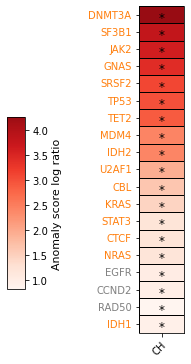

In [193]:
df_anomaly, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(df, 
                                                                                  cohort_df, 
                                                                                  top_cohorts_n=top_cohorts_n, 
                                                                                  top_genes_n=top_genes_n, 
                                                                                  anomaly_dict=anomaly_dict)

df_binary, hits_df, gene_hits_count, cohort_hits_count = get_gene_cohorts_binary(df, 
                                                                                 cohort_df, 
                                                                                 top_cohorts_n=top_cohorts_n, 
                                                                                 top_genes_n=top_genes_n, 
                                                                                 anomaly_dict=False)

df_binary.columns = [cohort.split("_")[2] for cohort in df_binary.columns]
df_anomaly.columns = [cohort.split("_")[2] for cohort in df_anomaly.columns]
gene_colors, lut = get_gene_annotation(df_binary, df)

plot_landscape(df=df_binary, gene_colors=gene_colors, lut=lut, df_anomaly=df_anomaly,
               figsize=(1,8),
               width_ratios=[1, 0.2],
               height_ratios=[0.3, 1],
               legend_box=(-10.5, 0.95),
               ax1_margin=0.005,
               ax4_margin=0.005,
               wspace=0.03, 
               hspace=0.05,
               cbar_loc=[-1.7, 0.2, 0.25, .3],
               filename="landscape_heatmap_ch.png")

# Mouse

In [283]:
genetables_path = "/workspace/projects/clustering_3d/evaluation/tool_output/run_20230608_mouse/Liver_strelka_2017.3d_clustering_genes.csv"
genetables_path

'/workspace/projects/clustering_3d/evaluation/tool_output/run_20230608_mouse/Liver_strelka_2017.3d_clustering_genes.csv'

In [284]:
df = pd.read_csv(genetables_path)
df = df[df["qval"] < 0.01]
df = df[["Gene", "Score_obs_sim_top_vol"]].set_index("Gene")
max_value = df.values[np.isfinite(df.values)].max()
df.replace([np.inf, -np.inf], max_value * 2, inplace=True)
df = np.log(df)
df

,Ratio_obs_sim_top_vol
Gene,
Hras,5.200429
Braf,4.507282
H2-M5,4.181026
Nrcam,4.026246
Ncl,3.545151
Itga9,3.314650
Nkx2-5,3.080942
Olfr1242,2.865297
Egfr,2.791804


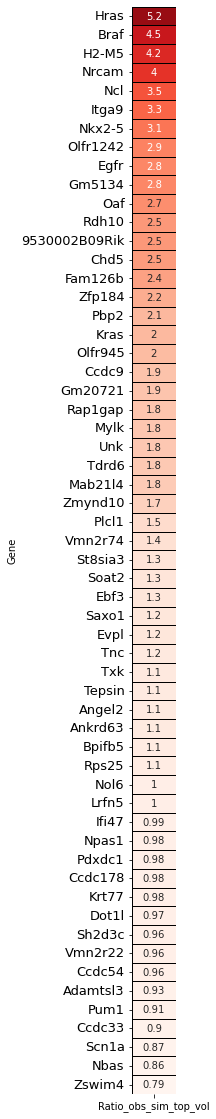

In [313]:
fig = plt.figure(figsize=(0.8,20))
sns.heatmap(df, annot=True, cmap=cmap, cbar=False, lw=1, linecolor="black")
plt.yticks(fontsize=13)

plt.savefig("landscape_mouse.png", dpi=300, bbox_inches='tight')
plt.show()

# Clusters solvent accessibility and more

In [685]:
import os
from tqdm.notebook import tqdm

o3d_datasets = "/workspace/nobackup/scratch/oncodrive3d/datasets_mane_240506"
cohort_df = pd.read_csv(f"{datasets}/cohorts.tsv", sep="\t")
seq_df = pd.read_csv(f"{o3d_datasets}/seq_for_mut_prob.tsv", sep="\t")
gene_to_uni_id_dict = {gene : uni_id for gene, uni_id in seq_df[["Gene", "Uniprot_ID"]].values}
plddt = pd.read_csv(f"{o3d_datasets}/confidence.tsv", sep="\t")
plddt = plddt[["Uniprot_ID", "Confidence"]]
pacc = pd.read_csv("/workspace/nobackup/scratch/oncodrive3d/annotations_mane_240506/pdb_tool_df.tsv", sep="\t")
pacc = pacc[["Uniprot_ID", "pACC"]]
intogen_df = pd.read_csv("/workspace/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/intogen_output/drivers.tsv", sep="\t")

/tmp/jobs/spellegrini/9964934/ipykernel_1413/2030990286.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  plddt = pd.read_csv(f"{o3d_datasets}/confidence.tsv", sep="\t")
/tmp/jobs/spellegrini/9964934/ipykernel_1413/2030990286.py:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  pacc = pd.read_csv("/workspace/nobackup/scratch/oncodrive3d/annotations_mane_240506/pdb_tool_df.tsv", sep="\t")


### Retrieve cluster mean of pACC and other metrics

In [770]:
%%time

lst_result = []
for cohort in cohort_df.COHORT:
    if not cohort.startswith("ICGC"):
        gene_df_path = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        res_df_path = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
        
        if os.path.isfile(gene_df_path) and os.path.isfile(res_df_path):
            gene_df = pd.read_csv(gene_df_path)
            res_df = pd.read_csv(res_df_path)

            hits = gene_df[gene_df["C_gene"] == 1]
            hits = hits["Gene"].values

            for gene in hits:
                print(cohort, gene)
                hits_res = res_df[(res_df["Gene"] == gene) & (res_df["C"] == 1)]
                plddt_gene = plddt[plddt["Uniprot_ID"] == gene_to_uni_id_dict[gene]]
                plddt_gene = plddt_gene.Confidence
                pacc_gene = pacc[pacc["Uniprot_ID"] == gene_to_uni_id_dict[gene]]
                pacc_gene = pacc_gene.pACC
                mean_values = hits_res.groupby("Cluster").apply(lambda x: lst_result.append((cohort, gene,
                                                                                             intogen_df[intogen_df["SYMBOL"] == gene].ROLE.unique()[0] 
                                                                                             if len(intogen_df[intogen_df["SYMBOL"] == gene].ROLE.unique()) > 0 
                                                                                             else "NA",
                                                                                             x.Cluster.unique()[0], x.Pos.values, 
                                                                                             np.mean(plddt_gene.iloc[x.Pos.values - 1]), 
                                                                                             np.mean(pacc_gene.iloc[x.Pos.values - 1]),
                                                                                             np.mean(x.PAE_vol))))

cluster_info = pd.DataFrame(lst_result, columns=["Cohort", "Gene", "Gene_action", "Cluster", "Pos", "pLDDT", "pACC", "PAE"])
cluster_info = cluster_info[cluster_info["Gene_action"] != "ambiguous"]
cluster_info

,Cohort,Gene,Gene_action,Cluster,Pos,pLDDT,pACC,PAE
0,HARTWIG_WGS_BLCA_2023,PIK3CA,Act,0.0,"[542, 545, 539]",93.733333,51.666667,0.841270
1,HARTWIG_WGS_BLCA_2023,RXRA,Act,0.0,"[427, 429]",97.750000,22.000000,0.500000
2,HARTWIG_WGS_BLCA_2023,FGFR3,Act,0.0,"[248, 249]",53.510000,30.000000,0.850000
3,HARTWIG_WGS_BLCA_2023,FGFR3,Act,1.0,[373],65.940000,72.000000,0.000000
4,HARTWIG_WGS_BLCA_2023,FBXW7,Act,0.0,"[505, 465]",98.680000,13.000000,0.500000
...,...,...,...,...,...,...,...,...
925,TCGA_WXS_SOFT_TISSUE,TP53,LoF,2.0,"[273, 275, 272, 270, 132, 281, 278]",98.231429,7.857143,0.798923
926,TCGA_WXS_SOFT_TISSUE,TP53,LoF,3.0,"[158, 156, 220, 203]",97.357500,16.250000,0.825893
927,TCGA_WXS_PGNG,HRAS,Act,0.0,[13],94.820000,36.000000,4.444444
928,TCGA_WXS_PGNG,HRAS,Act,1.0,[61],85.100000,34.000000,0.000000


### Plot distributions

In [726]:
df_info_na = cluster_info[cluster_info["Gene_action"] == "NA"].groupby("Gene").apply(lambda x: (len(x.Cohort.unique()), len(x)))
pd.DataFrame(df_info_na.tolist(), index=df_info_na.index, columns=["# cohorts", "# clusters"]).sort_values("# clusters", ascending=False)[:30]

,# cohorts,# clusters
Gene,,
IGLL5,2,14
EGR1,1,4
AHNAK2,2,3
OR5H14,2,2
ESX1,2,2
TBR1,2,2
GBP4,2,2
HLA-DQB1,2,2
RETSAT,2,2


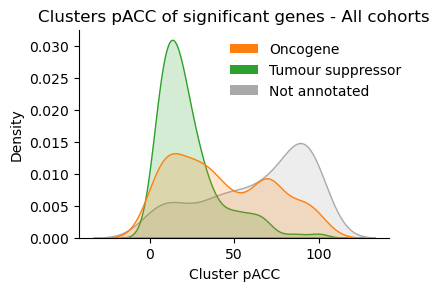

In [785]:
lut = {"Act": '#ff7f0e', 
       "LoF": '#2ca02c',
       "ambiguous" : "#b300b2",
       "NA": 'darkgray'}

## Plot 
plt.figure(figsize=(4, 2.7))
palette = {'Act': '#ff7f0e', 'LoF': '#2ca02c', "ambiguous" : "#b300b2", 'NA': 'darkgray'}
sns.kdeplot(data=cluster_info, x='pACC', hue='Gene_action', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Cluster pACC')
plt.ylabel('Density')
plt.title("Clusters pACC of significant genes - All cohorts", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["Act"], label="Oncogene"),
           mpatches.Patch(facecolor=lut["LoF"], label="Tumour suppressor"),
           mpatches.Patch(facecolor=lut["NA"], label="Not annotated")]
plt.legend(handles=handles, frameon=False, bbox_to_anchor=[0,0,1.08,1])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.savefig("pacc_cluster_distribution_by_action.png", dpi=300, bbox_inches='tight')
plt.show()

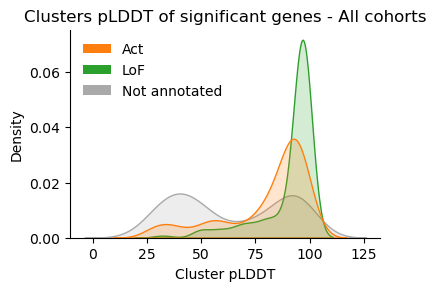

In [779]:
lut = {"Act": '#ff7f0e', 
       "LoF": '#2ca02c',
       "ambiguous" : "#b300b2",
       "NA": 'darkgray'}

## Plot 
plt.figure(figsize=(4, 2.7))
palette = {'Act': '#ff7f0e', 'LoF': '#2ca02c', "ambiguous" : "#b300b2", 'NA': 'darkgray'}
sns.kdeplot(data=cluster_info, x='pLDDT', hue='Gene_action', fill=True, common_norm=False, palette=palette, alpha=0.2)

# Add labels and a legend
plt.xlabel('Cluster pLDDT')
plt.ylabel('Density')
plt.title("Clusters pLDDT of significant genes - All cohorts", fontsize=12)

handles = [mpatches.Patch(facecolor=lut["Act"], label="Act"),
           mpatches.Patch(facecolor=lut["LoF"], label="LoF"),
           mpatches.Patch(facecolor=lut["NA"], label="Not annotated")]
plt.legend(handles=handles, loc="upper left", frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("plddt_cluster_distribution_by_action.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/jobs/spellegrini/9964934/ipykernel_1413/1621273303.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=cluster_info, x='PAE', fill=True, common_norm=False, palette=palette, alpha=0.2, color="skyblue")


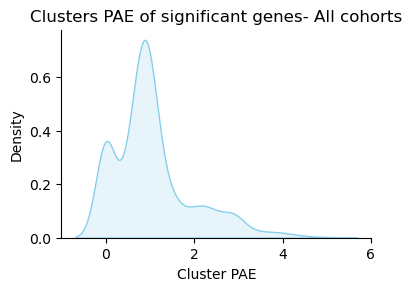

In [794]:
lut = {"Act": '#ff7f0e', 
       "LoF": '#2ca02c',
       "ambiguous" : "#b300b2",
       "NA": '#7f7f7f'}

# ## Plot 
# plt.figure(figsize=(6, 4))
# palette = {'Act': '#ff7f0e', 'LoF': '#2ca02c', "ambiguous" : "#b300b2", 'NA': '#7f7f7f'}
# sns.kdeplot(data=cluster_info, x='PAE', hue='Gene_action', fill=True, common_norm=False, palette=palette, alpha=0.2)

# # Add labels and a legend
# plt.xlabel('Cluster PAE')
# plt.ylabel('Density')
# plt.title("Clusters PAE of significant genes - All cohorts", fontsize=12)

# handles = [mpatches.Patch(facecolor=lut["Act"], label="Act"),
#            mpatches.Patch(facecolor=lut["LoF"], label="LoF"),
#            mpatches.Patch(facecolor=lut["ambiguous"], label="ambiguous"),
#            mpatches.Patch(facecolor=lut["NA"], label="NA")]
# plt.legend(handles=handles)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.savefig("pae_cluster_distribution_by_action.png", dpi=300, bbox_inches='tight')
# plt.show()

## Plot 
plt.figure(figsize=(4, 2.7))
palette = {'Act': '#ff7f0e', 'LoF': '#2ca02c', "ambiguous" : "#b300b2", 'NA': '#7f7f7f'}
sns.kdeplot(data=cluster_info, x='PAE', fill=True, common_norm=False, palette=palette, alpha=0.2, color="skyblue")

# Add labels and a legend
plt.xlabel('Cluster PAE')
plt.ylabel('Density')
plt.title("Clusters PAE of significant genes- All cohorts", fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("pae_cluster_distribution.png", dpi=300, bbox_inches='tight')
plt.show()